# Stock Price Prediction based on Cryptocurrency Price

In [ ]:
!pip install keras
!pip install arch
!pip install fredapi
!pip install yfinance
!pip install pandas_datareader

  ### Importing necessary libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error,  mean_absolute_percentage_error, r2_score
from fredapi import Fred
import pandas_datareader.data as web
import datetime
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from arch import arch_model
import warnings
from arch import arch_model
from scipy.optimize import minimize
import matplotlib.dates as mdates
from sklearn.model_selection import GridSearchCV

In [4]:
# Ignore all warnings
warnings.filterwarnings('ignore')

### Data Collection

Reading the historical data of major stocks and cryptocurrencies

In [5]:
# Define the date range for the data
start = datetime.datetime(2018, 1, 1)
end = datetime.datetime(2024, 5, 5)

In [6]:
# Define the assets to be gathered
crypto_names = ["BTC-USD", "ETH-USD", "XRP-USD", "LTC-USD"]
stock_names = ["^IXIC", "^GSPC", "^DJI"]
macro_indicators = {
    'GDP': 'GDPC1',  # Real Gross Domestic Product
    'Unemployment Rate': 'UNRATE',  # Unemployment Rate
    'Consumer Price Index': 'CPIAUCSL',  # Consumer Price Index for All Urban Consumers
    'Federal Funds Rate': 'FEDFUNDS',  # Effective Federal Funds Rate
    '10-Year Treasury Constant Maturity Rate': 'GS10'  # 10-Year Treasury Constant Maturity Rate
}

In [7]:
tickers = ["BTC-USD", "ETH-USD", "XRP-USD", "LTC-USD", "^IXIC", "^GSPC", "^DJI"]

In [8]:
file_names = []

for ticker in tickers:
    data = yf.download(ticker, start, end+datetime.timedelta(days=1))
    data.columns = [f"{ticker}_{col}" for col in data.columns]
    file_name = ticker + '.csv'
    data.to_csv(file_name)
    file_names.append(file_name)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [9]:
# Fetch macroeconomic data
macro_data = {}
for name, ticker in macro_indicators.items():
    macro_data[name] = web.DataReader(ticker, 'fred', start, end)
    macro_data[name].rename(columns={ticker: name}, inplace=True)

In [10]:
# Create a date range for all months within the specified period
all_dates = pd.date_range(start=start, end=end, freq='D')

# Function to fill missing months and forward fill the values
def fill_missing_months(df):
    df = df.reindex(all_dates)
    df.fillna(method='ffill', inplace=True)
    return df

In [11]:
# Apply the function to each DataFrame in macro_data
filled_macro_data = {name: fill_missing_months(df) for name, df in macro_data.items()}

# Combine all the macroeconomic data into a single DataFrame
combined_macro_data = pd.concat(filled_macro_data.values(), axis=1)

# Reset index to have 'Date' as a column
combined_macro_data.index.name = 'Date'
combined_macro_data.reset_index(inplace=True)

# Display the combined macroeconomic data
print(combined_macro_data)

# Save the combined macroeconomic data to a CSV file
combined_macro_data.to_csv('combined_macro_data.csv')

           Date        GDP  Unemployment Rate  Consumer Price Index  \
0    2018-01-01  20044.077                4.0               248.859   
1    2018-01-02  20044.077                4.0               248.859   
2    2018-01-03  20044.077                4.0               248.859   
3    2018-01-04  20044.077                4.0               248.859   
4    2018-01-05  20044.077                4.0               248.859   
...         ...        ...                ...                   ...   
2312 2024-05-01  22924.863                4.0               313.225   
2313 2024-05-02  22924.863                4.0               313.225   
2314 2024-05-03  22924.863                4.0               313.225   
2315 2024-05-04  22924.863                4.0               313.225   
2316 2024-05-05  22924.863                4.0               313.225   

      Federal Funds Rate  10-Year Treasury Constant Maturity Rate  
0                   1.41                                     2.58  
1          

In [12]:
dfs = {ticker: pd.read_csv(filename) for ticker, filename in zip(tickers, file_names)}

In [13]:
df_btc = dfs['BTC-USD']
df_eth = dfs['ETH-USD']
df_xrp = dfs['XRP-USD']
df_ltc = dfs['LTC-USD']
df_ndaq = dfs['^IXIC']
df_sp500 = dfs['^GSPC']
df_dji = dfs['^DJI']

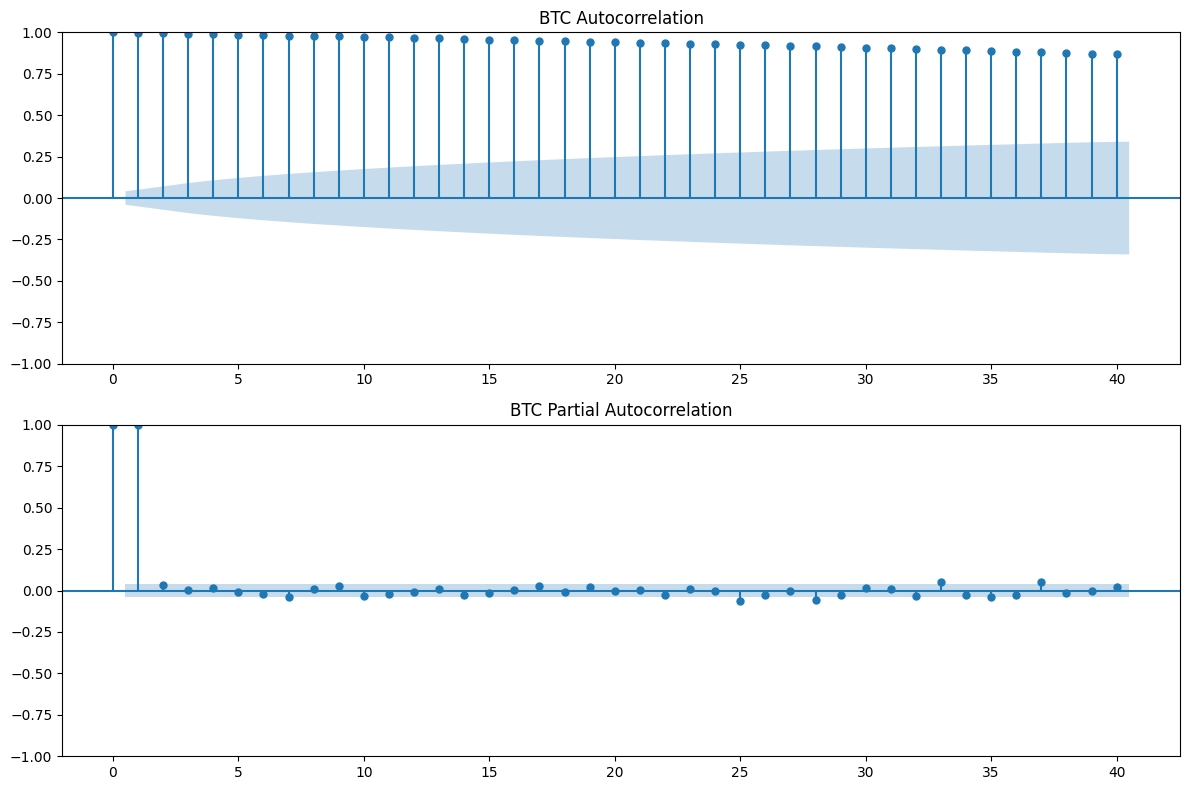

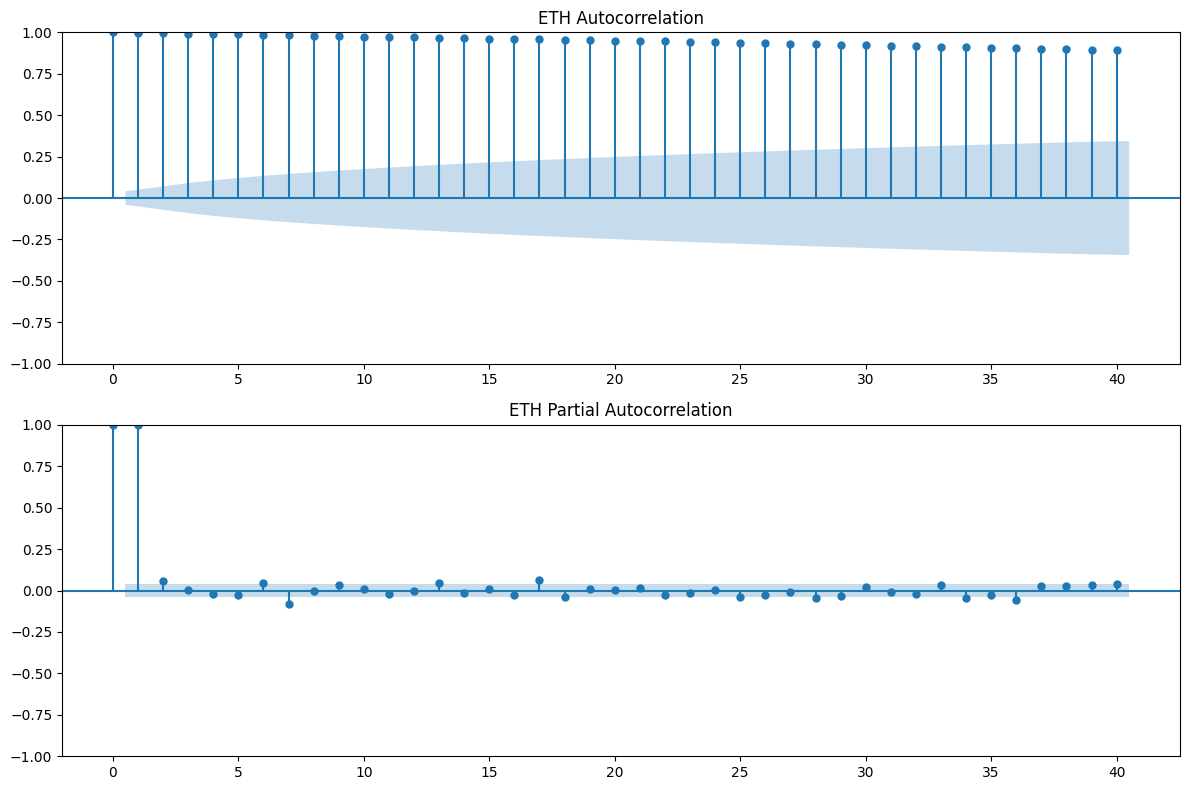

In [14]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming BTC and ETH data are stored in btc_data and eth_data respectively
# Replace btc_data and eth_data with your actual data variables

# Plot ACF and PACF for BTC
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_btc['BTC-USD_Adj Close'], lags=40, ax=axes[0])
axes[0].set_title('BTC Autocorrelation')
plot_pacf(df_btc['BTC-USD_Adj Close'], lags=40, ax=axes[1])
axes[1].set_title('BTC Partial Autocorrelation')
plt.tight_layout()
plt.show()

# Plot ACF and PACF for ETH
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_eth['ETH-USD_Adj Close'], lags=40, ax=axes[0])
axes[0].set_title('ETH Autocorrelation')
plot_pacf(df_eth['ETH-USD_Adj Close'], lags=40, ax=axes[1])
axes[1].set_title('ETH Partial Autocorrelation')
plt.tight_layout()
plt.show()


In [15]:
df_eth

,Date,ETH-USD_Open,ETH-USD_High,ETH-USD_Low,ETH-USD_Close,ETH-USD_Adj Close,ETH-USD_Volume
0,2018-01-01,755.757019,782.530029,742.004028,772.640991,772.640991,2595760128
1,2018-01-02,772.346008,914.830017,772.346008,884.443970,884.443970,5783349760
2,2018-01-03,886.000000,974.471008,868.450989,962.719971,962.719971,5093159936
3,2018-01-04,961.713013,1045.079956,946.085999,980.921997,980.921997,6502859776
4,2018-01-05,975.750000,1075.390015,956.325012,997.719971,997.719971,6683149824
...,...,...,...,...,...,...,...
2312,2024-05-01,3011.015625,3020.173340,2815.923340,2969.784668,2969.784668,20005057445
2313,2024-05-02,2969.794434,3015.050293,2894.329834,2988.168457,2988.168457,13163903903
2314,2024-05-03,2988.134521,3127.155273,2960.182129,3103.541992,3103.541992,12862183229
2315,2024-05-04,3103.619629,3167.541260,3096.267578,3117.576416,3117.576416,8283229638


In [16]:
df_macro = pd.read_csv('combined_macro_data.csv')
df_macro

,Unnamed: 0,Date,GDP,Unemployment Rate,Consumer Price Index,Federal Funds Rate,10-Year Treasury Constant Maturity Rate
0,0,2018-01-01,20044.077,4.0,248.859,1.41,2.58
1,1,2018-01-02,20044.077,4.0,248.859,1.41,2.58
2,2,2018-01-03,20044.077,4.0,248.859,1.41,2.58
3,3,2018-01-04,20044.077,4.0,248.859,1.41,2.58
4,4,2018-01-05,20044.077,4.0,248.859,1.41,2.58
...,...,...,...,...,...,...,...
2312,2312,2024-05-01,22924.863,4.0,313.225,5.33,4.48
2313,2313,2024-05-02,22924.863,4.0,313.225,5.33,4.48
2314,2314,2024-05-03,22924.863,4.0,313.225,5.33,4.48
2315,2315,2024-05-04,22924.863,4.0,313.225,5.33,4.48


### Data Preprocessing

In [17]:
scaler = StandardScaler()

def cleaning_and_preprocessing(df):

    if 'Close' in df.columns:
        del df['Close']
    if 'Unnamed: 0' in df.columns:
        del df['Unnamed: 0']

    if 'Date' in df.columns:
        df.set_index(df['Date'], inplace=True)
        del df['Date']

    df.columns = df.columns.str.lower().str.replace(' ','_')
    df = df.fillna(0)

    # Fit and transform the data using StandardScaler
    scaled_data = scaler.fit_transform(df)

    # Convert the scaled data back to a DataFrame, preserving the index and column names
    df = pd.DataFrame(scaled_data, index=df.index, columns=df.columns)

    return df

In [18]:
df_macro_clean = cleaning_and_preprocessing(df_macro)
df_btc_clean = cleaning_and_preprocessing(df_btc)
df_eth_clean = cleaning_and_preprocessing(df_eth)
df_xrp_clean = cleaning_and_preprocessing(df_xrp)
df_ltc_clean = cleaning_and_preprocessing(df_ltc)
df_ndaq_clean = cleaning_and_preprocessing(df_ndaq)
df_sp500_clean = cleaning_and_preprocessing(df_sp500)
df_dji_clean = cleaning_and_preprocessing(df_dji)

In [19]:
df_btc_clean

,btc-usd_open,btc-usd_high,btc-usd_low,btc-usd_close,btc-usd_adj_close,btc-usd_volume
Date,,,,,,
2018-01-01,-0.540191,-0.557091,-0.577288,-0.566584,-0.566584,-0.824171
2018-01-02,-0.567797,-0.483404,-0.576770,-0.491578,-0.491578,-0.473150
2018-01-03,-0.491120,-0.476314,-0.478824,-0.479186,-0.479186,-0.471795
2018-01-04,-0.474546,-0.467083,-0.497604,-0.456642,-0.456642,-0.208810
2018-01-05,-0.462845,-0.358383,-0.457946,-0.353024,-0.353024,-0.098627
...,...,...,...,...,...,...
2024-05-01,2.094513,2.023869,1.951663,1.958164,1.958164,1.218567
2024-05-02,1.961025,1.958709,1.973917,2.007384,2.007384,0.376383
2024-05-03,2.010243,2.164342,2.085278,2.220611,2.220611,0.401026


In [20]:
df_macro_clean

,gdp,unemployment_rate,consumer_price_index,federal_funds_rate,10-year_treasury_constant_maturity_rate
Date,,,,,
2018-01-01,-1.244929,-0.310591,-1.186903,-0.342827,0.082552
2018-01-02,-1.244929,-0.310591,-1.186903,-0.342827,0.082552
2018-01-03,-1.244929,-0.310591,-1.186903,-0.342827,0.082552
2018-01-04,-1.244929,-0.310591,-1.186903,-0.342827,0.082552
2018-01-05,-1.244929,-0.310591,-1.186903,-0.342827,0.082552
...,...,...,...,...,...
2024-05-01,1.820866,-0.310591,1.796605,1.761470,1.733929
2024-05-02,1.820866,-0.310591,1.796605,1.761470,1.733929
2024-05-03,1.820866,-0.310591,1.796605,1.761470,1.733929


### Correlation Analysis

In [21]:
combined_cleaned_data = pd.concat([df_macro_clean, df_btc_clean, df_eth_clean, df_xrp_clean, df_ltc_clean, df_ndaq_clean, df_sp500_clean, df_dji_clean], axis=1)

In [22]:
combined_cleaned_data.columns

Index(['gdp', 'unemployment_rate', 'consumer_price_index',
       'federal_funds_rate', '10-year_treasury_constant_maturity_rate',
       'btc-usd_open', 'btc-usd_high', 'btc-usd_low', 'btc-usd_close',
       'btc-usd_adj_close', 'btc-usd_volume', 'eth-usd_open', 'eth-usd_high',
       'eth-usd_low', 'eth-usd_close', 'eth-usd_adj_close', 'eth-usd_volume',
       'xrp-usd_open', 'xrp-usd_high', 'xrp-usd_low', 'xrp-usd_close',
       'xrp-usd_adj_close', 'xrp-usd_volume', 'ltc-usd_open', 'ltc-usd_high',
       'ltc-usd_low', 'ltc-usd_close', 'ltc-usd_adj_close', 'ltc-usd_volume',
       '^ixic_open', '^ixic_high', '^ixic_low', '^ixic_close',
       '^ixic_adj_close', '^ixic_volume', '^gspc_open', '^gspc_high',
       '^gspc_low', '^gspc_close', '^gspc_adj_close', '^gspc_volume',
       '^dji_open', '^dji_high', '^dji_low', '^dji_close', '^dji_adj_close',
       '^dji_volume'],
      dtype='object')

In [23]:
columns_close = [
'gdp', 'unemployment_rate', 'consumer_price_index', 'federal_funds_rate', '10-year_treasury_constant_maturity_rate', 'btc-usd_adj_close',
'eth-usd_adj_close', 'xrp-usd_adj_close', 'ltc-usd_adj_close', '^ixic_adj_close', '^gspc_adj_close', '^dji_adj_close'
]

In [24]:
# Assuming `cleaned_data` is a combined DataFrame of cleaned and preprocessed data
correlation_matrix = combined_cleaned_data[columns_close].corr()
print(correlation_matrix)

                                              gdp  unemployment_rate  \
gdp                                      1.000000          -0.511461   
unemployment_rate                       -0.511461           1.000000   
consumer_price_index                     0.926118          -0.305744   
federal_funds_rate                       0.611055          -0.479441   
10-year_treasury_constant_maturity_rate  0.621897          -0.613033   
btc-usd_adj_close                        0.678100          -0.093485   
eth-usd_adj_close                        0.698143          -0.196074   
xrp-usd_adj_close                        0.183662          -0.167635   
ltc-usd_adj_close                        0.063089          -0.048198   
^ixic_adj_close                          0.762339          -0.015069   
^gspc_adj_close                          0.866705          -0.170858   
^dji_adj_close                           0.882232          -0.252098   

                                         consumer_price_index  

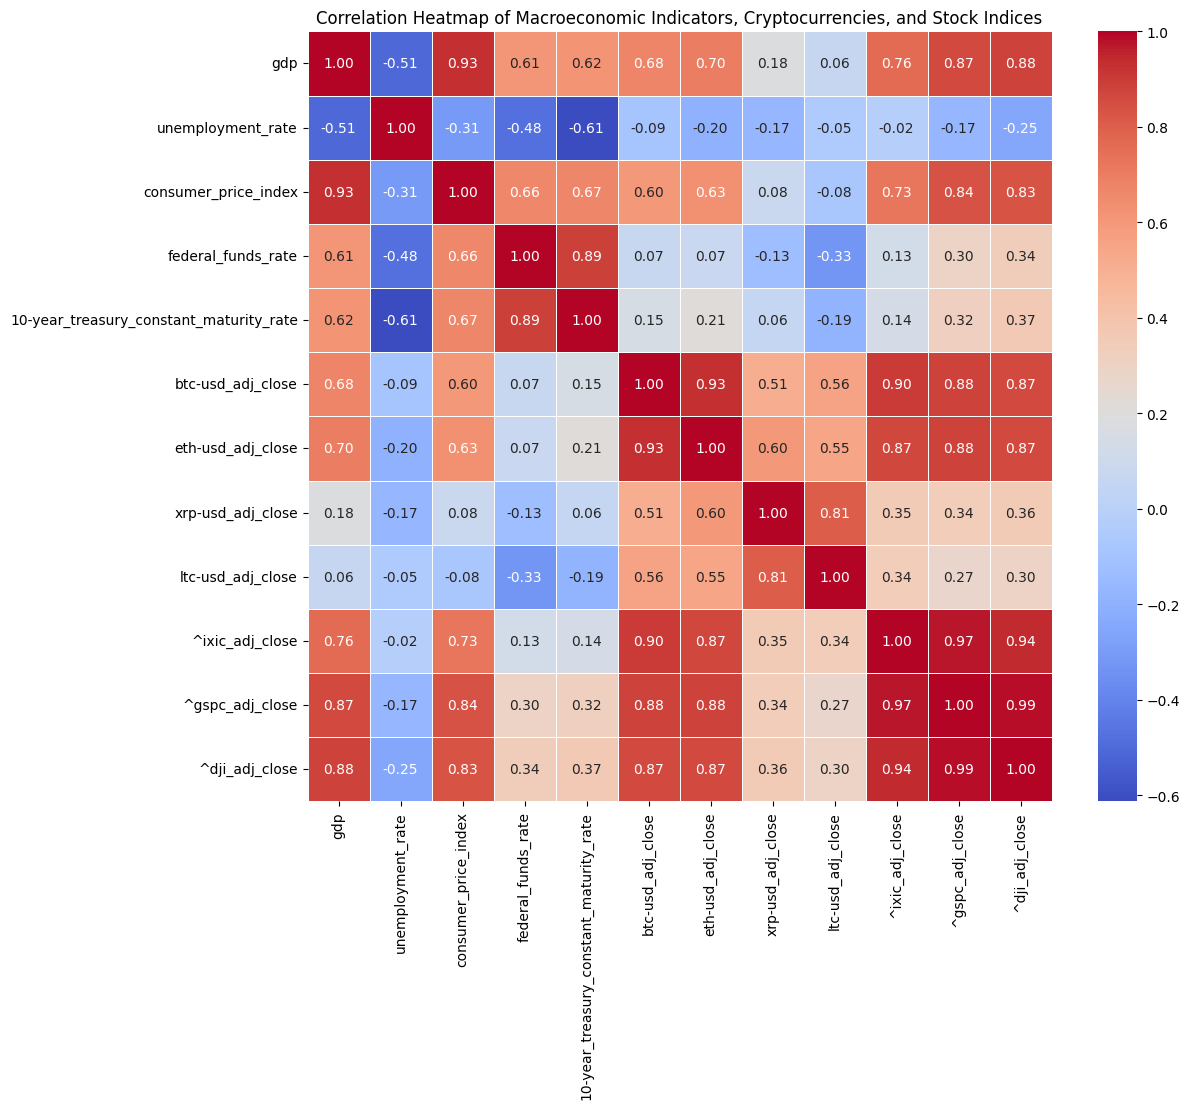

In [25]:
# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5)

# Set titles and labels
plt.title('Correlation Heatmap of Macroeconomic Indicators, Cryptocurrencies, and Stock Indices')
plt.show()

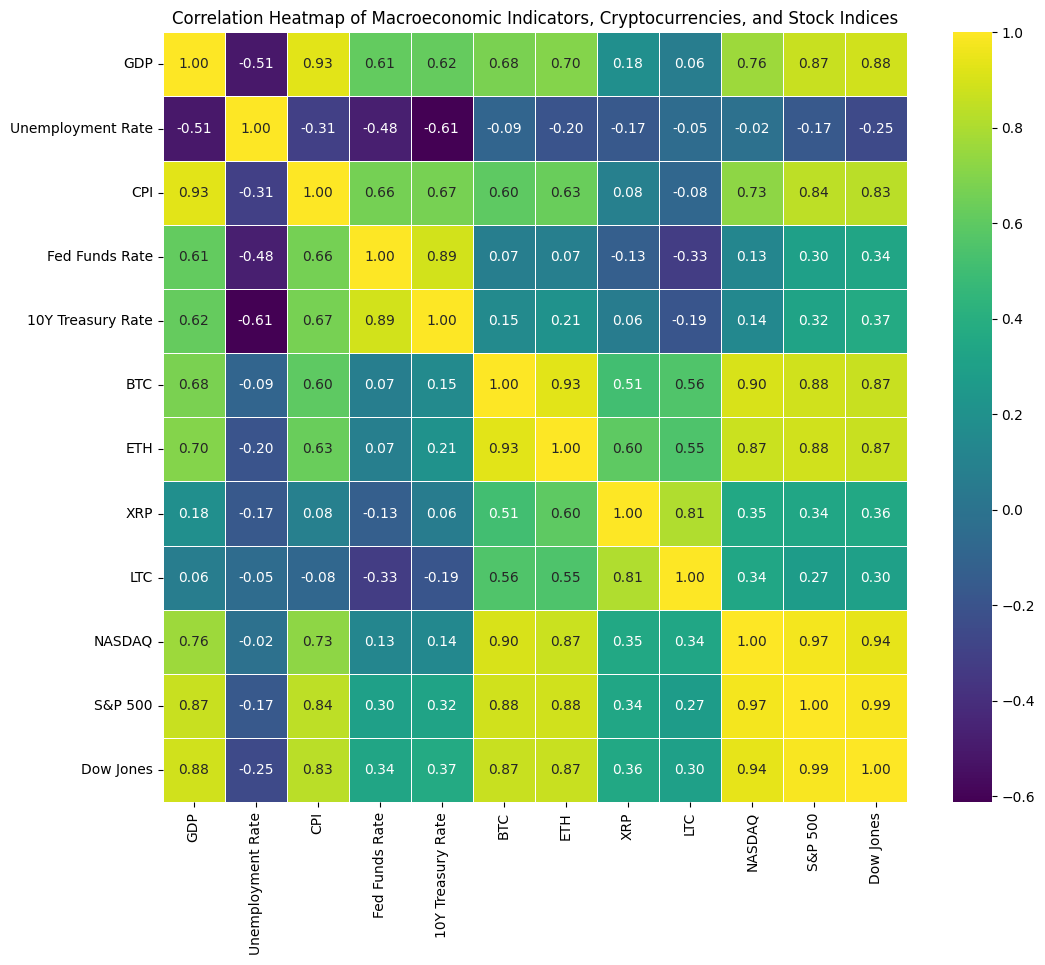

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming cleaned_data is your DataFrame with the relevant columns
columns_close = [
    'gdp', 'unemployment_rate', 'consumer_price_index', 'federal_funds_rate',
    '10-year_treasury_constant_maturity_rate', 'btc-usd_adj_close', 'eth-usd_adj_close',
    'xrp-usd_adj_close', 'ltc-usd_adj_close', '^ixic_adj_close', '^gspc_adj_close', '^dji_adj_close'
]

# Create a dictionary for renaming labels
label_map = {
    'gdp': 'GDP',
    'unemployment_rate': 'Unemployment Rate',
    'consumer_price_index': 'CPI',
    'federal_funds_rate': 'Fed Funds Rate',
    '10-year_treasury_constant_maturity_rate': '10Y Treasury Rate',
    'btc-usd_adj_close': 'BTC',
    'eth-usd_adj_close': 'ETH',
    'xrp-usd_adj_close': 'XRP',
    'ltc-usd_adj_close': 'LTC',
    '^ixic_adj_close': 'NASDAQ',
    '^gspc_adj_close': 'S&P 500',
    '^dji_adj_close': 'Dow Jones'
}

# Compute the correlation matrix
correlation_matrix = combined_cleaned_data[columns_close].corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with renamed labels
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    linewidths=.5,
    xticklabels=[label_map[col] for col in columns_close],
    yticklabels=[label_map[col] for col in columns_close]
)

# Set titles and labels
plt.title('Correlation Heatmap of Macroeconomic Indicators, Cryptocurrencies, and Stock Indices')
plt.show()

In [27]:
columns_stock_crypto = [
'btc-usd_adj_close', 'eth-usd_adj_close', 'xrp-usd_adj_close', 'ltc-usd_adj_close', '^ixic_adj_close', '^gspc_adj_close', '^dji_adj_close'
]

In [28]:
correlation_matrix_stock_crypto = combined_cleaned_data[columns_stock_crypto].corr()
print(correlation_matrix_stock_crypto)

                   btc-usd_adj_close  eth-usd_adj_close  xrp-usd_adj_close  \
btc-usd_adj_close           1.000000           0.927900           0.513965   
eth-usd_adj_close           0.927900           1.000000           0.601595   
xrp-usd_adj_close           0.513965           0.601595           1.000000   
ltc-usd_adj_close           0.555187           0.551491           0.806229   
^ixic_adj_close             0.903087           0.869980           0.352264   
^gspc_adj_close             0.882414           0.880861           0.338790   
^dji_adj_close              0.866427           0.865753           0.355566   

                   ltc-usd_adj_close  ^ixic_adj_close  ^gspc_adj_close  \
btc-usd_adj_close           0.555187         0.903087         0.882414   
eth-usd_adj_close           0.551491         0.869980         0.880861   
xrp-usd_adj_close           0.806229         0.352264         0.338790   
ltc-usd_adj_close           1.000000         0.341230         0.271648   
^ixic

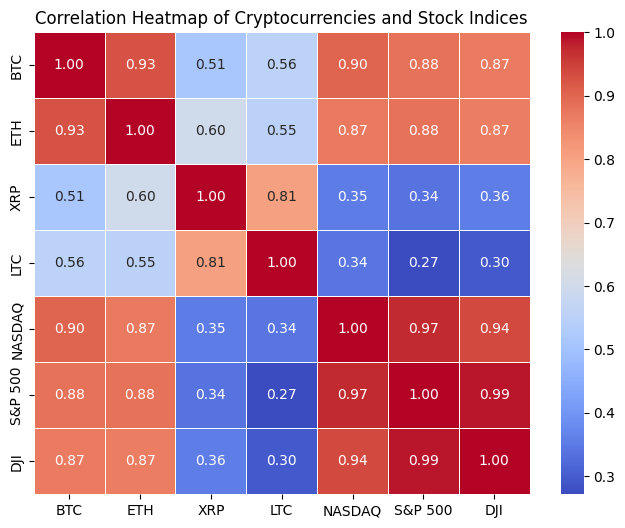

In [29]:
# Rename the columns for better readability
correlation_matrix_stock_crypto.columns = ['BTC', 'ETH', 'XRP', 'LTC', 'NASDAQ', 'S&P 500', 'DJI']
correlation_matrix_stock_crypto.index = ['BTC', 'ETH', 'XRP', 'LTC', 'NASDAQ', 'S&P 500', 'DJI']

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Draw the heatmap
sns.heatmap(correlation_matrix_stock_crypto, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5)

# Set titles and labels
plt.title('Correlation Heatmap of Cryptocurrencies and Stock Indices')
plt.show()


### Regression Analysis

In [30]:
cryptos = ['btc-usd_adj_close', 'eth-usd_adj_close', 'xrp-usd_adj_close', 'ltc-usd_adj_close']
stocks = ['^gspc_adj_close', '^ixic_adj_close', '^dji_adj_close']
macro_indicators = ['gdp', 'unemployment_rate', 'consumer_price_index', 'federal_funds_rate', '10-year_treasury_constant_maturity_rate']

In [31]:
def perform_regression(y, X, y_label, X_label):
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    print(f"Regression Analysis: {y_label} vs {X_label}")
    print(model.summary())
    print("\n\n")

In [32]:
combined_cleaned_data = combined_cleaned_data.fillna(method='ffill').fillna(method='bfill')

In [33]:
# Perform regression analysis for each crypto vs each stock
for crypto in cryptos:
    y = combined_cleaned_data[crypto]
    for stock in stocks:
        X = combined_cleaned_data[[stock]]
        perform_regression(y, X, crypto, stock)

Regression Analysis: btc-usd_adj_close vs ^gspc_adj_close
                            OLS Regression Results                            
Dep. Variable:      btc-usd_adj_close   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     8142.
Date:                Sun, 08 Sep 2024   Prob (F-statistic):               0.00
Time:                        17:06:09   Log-Likelihood:                -1540.9
No. Observations:                2317   AIC:                             3086.
Df Residuals:                    2315   BIC:                             3097.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

In [34]:
# Perform regression analysis for each macroindicator vs each stock
for macro_indicator in macro_indicators:
    y = combined_cleaned_data[macro_indicator]
    for stock in stocks:
        X = combined_cleaned_data[[stock]]
        perform_regression(y, X, macro_indicator, stock)

Regression Analysis: gdp vs ^gspc_adj_close
                            OLS Regression Results                            
Dep. Variable:                    gdp   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     7066.
Date:                Sun, 08 Sep 2024   Prob (F-statistic):               0.00
Time:                        17:06:09   Log-Likelihood:                -1666.7
No. Observations:                2317   AIC:                             3337.
Df Residuals:                    2315   BIC:                             3349.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

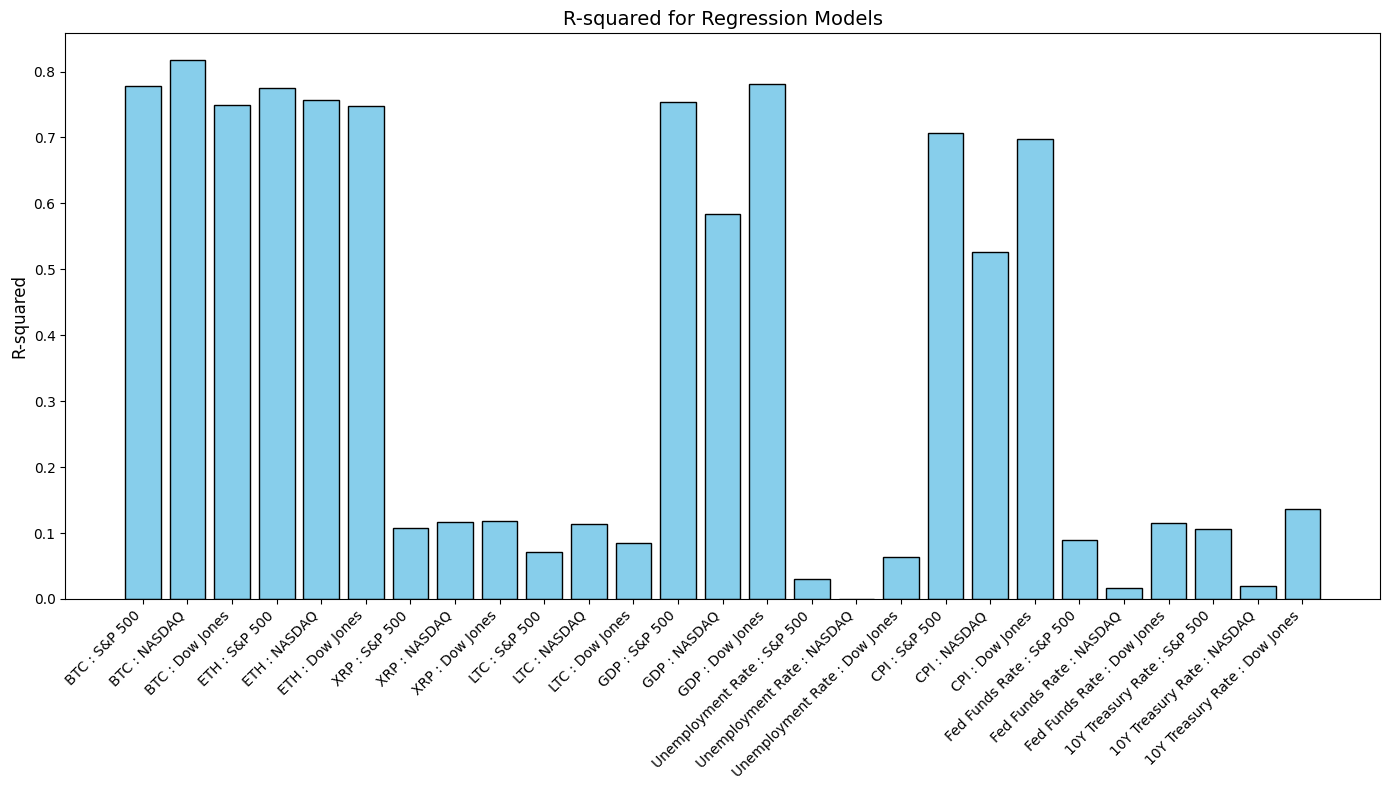

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Define the mapping for better labels
label_map = {
    'btc-usd_adj_close': 'BTC',
    'eth-usd_adj_close': 'ETH',
    'xrp-usd_adj_close': 'XRP',
    'ltc-usd_adj_close': 'LTC',
    '^gspc_adj_close': 'S&P 500',
    '^ixic_adj_close': 'NASDAQ',
    '^dji_adj_close': 'Dow Jones',
    'gdp': 'GDP',
    'unemployment_rate': 'Unemployment Rate',
    'consumer_price_index': 'CPI',
    'federal_funds_rate': 'Fed Funds Rate',
    '10-year_treasury_constant_maturity_rate': '10Y Treasury Rate'
}

# Generate the custom labels with a consistent format
custom_labels = [
    f"{label_map[row['Dependent Variable']]} : {label_map[row['Independent Variable']]}"
    for _, row in results_summary.iterrows()
]

# Create the bar plot
plt.figure(figsize=(14, 8))
bars = plt.bar(
    x=custom_labels,
    height=results_summary['R-squared'],
    color='skyblue',
    edgecolor='black'
)

# Improve label formatting
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylabel('R-squared', fontsize=12)
plt.title('R-squared for Regression Models', fontsize=14)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

### Multivariate VAR Model

In [43]:
# Select the relevant columns for the VAR model
model_data = combined_cleaned_data[cryptos + stocks]

# Fill any missing values
model_data = model_data.fillna(method='ffill').fillna(method='bfill')

In [44]:
# Fit the VAR model
model = VAR(model_data)
results = model.fit(maxlags=15, ic='aic')
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 08, Sep, 2024
Time:                     17:06:36
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -43.0221
Nobs:                     2302.00    HQIC:                  -44.1981
Log likelihood:           29525.8    FPE:                3.25230e-20
AIC:                     -44.8728    Det(Omega_mle):     2.37319e-20
--------------------------------------------------------------------
Results for equation btc-usd_adj_close
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                         0.000440         0.001205            0.365           0.715
L1.btc-usd_adj_close          1.026667         0.034627           29.649           0.000
L1.eth-usd_adj_c

In [45]:
# Calculate impulse response functions
irf = results.irf(10)  # 10 periods can be adjusted as needed

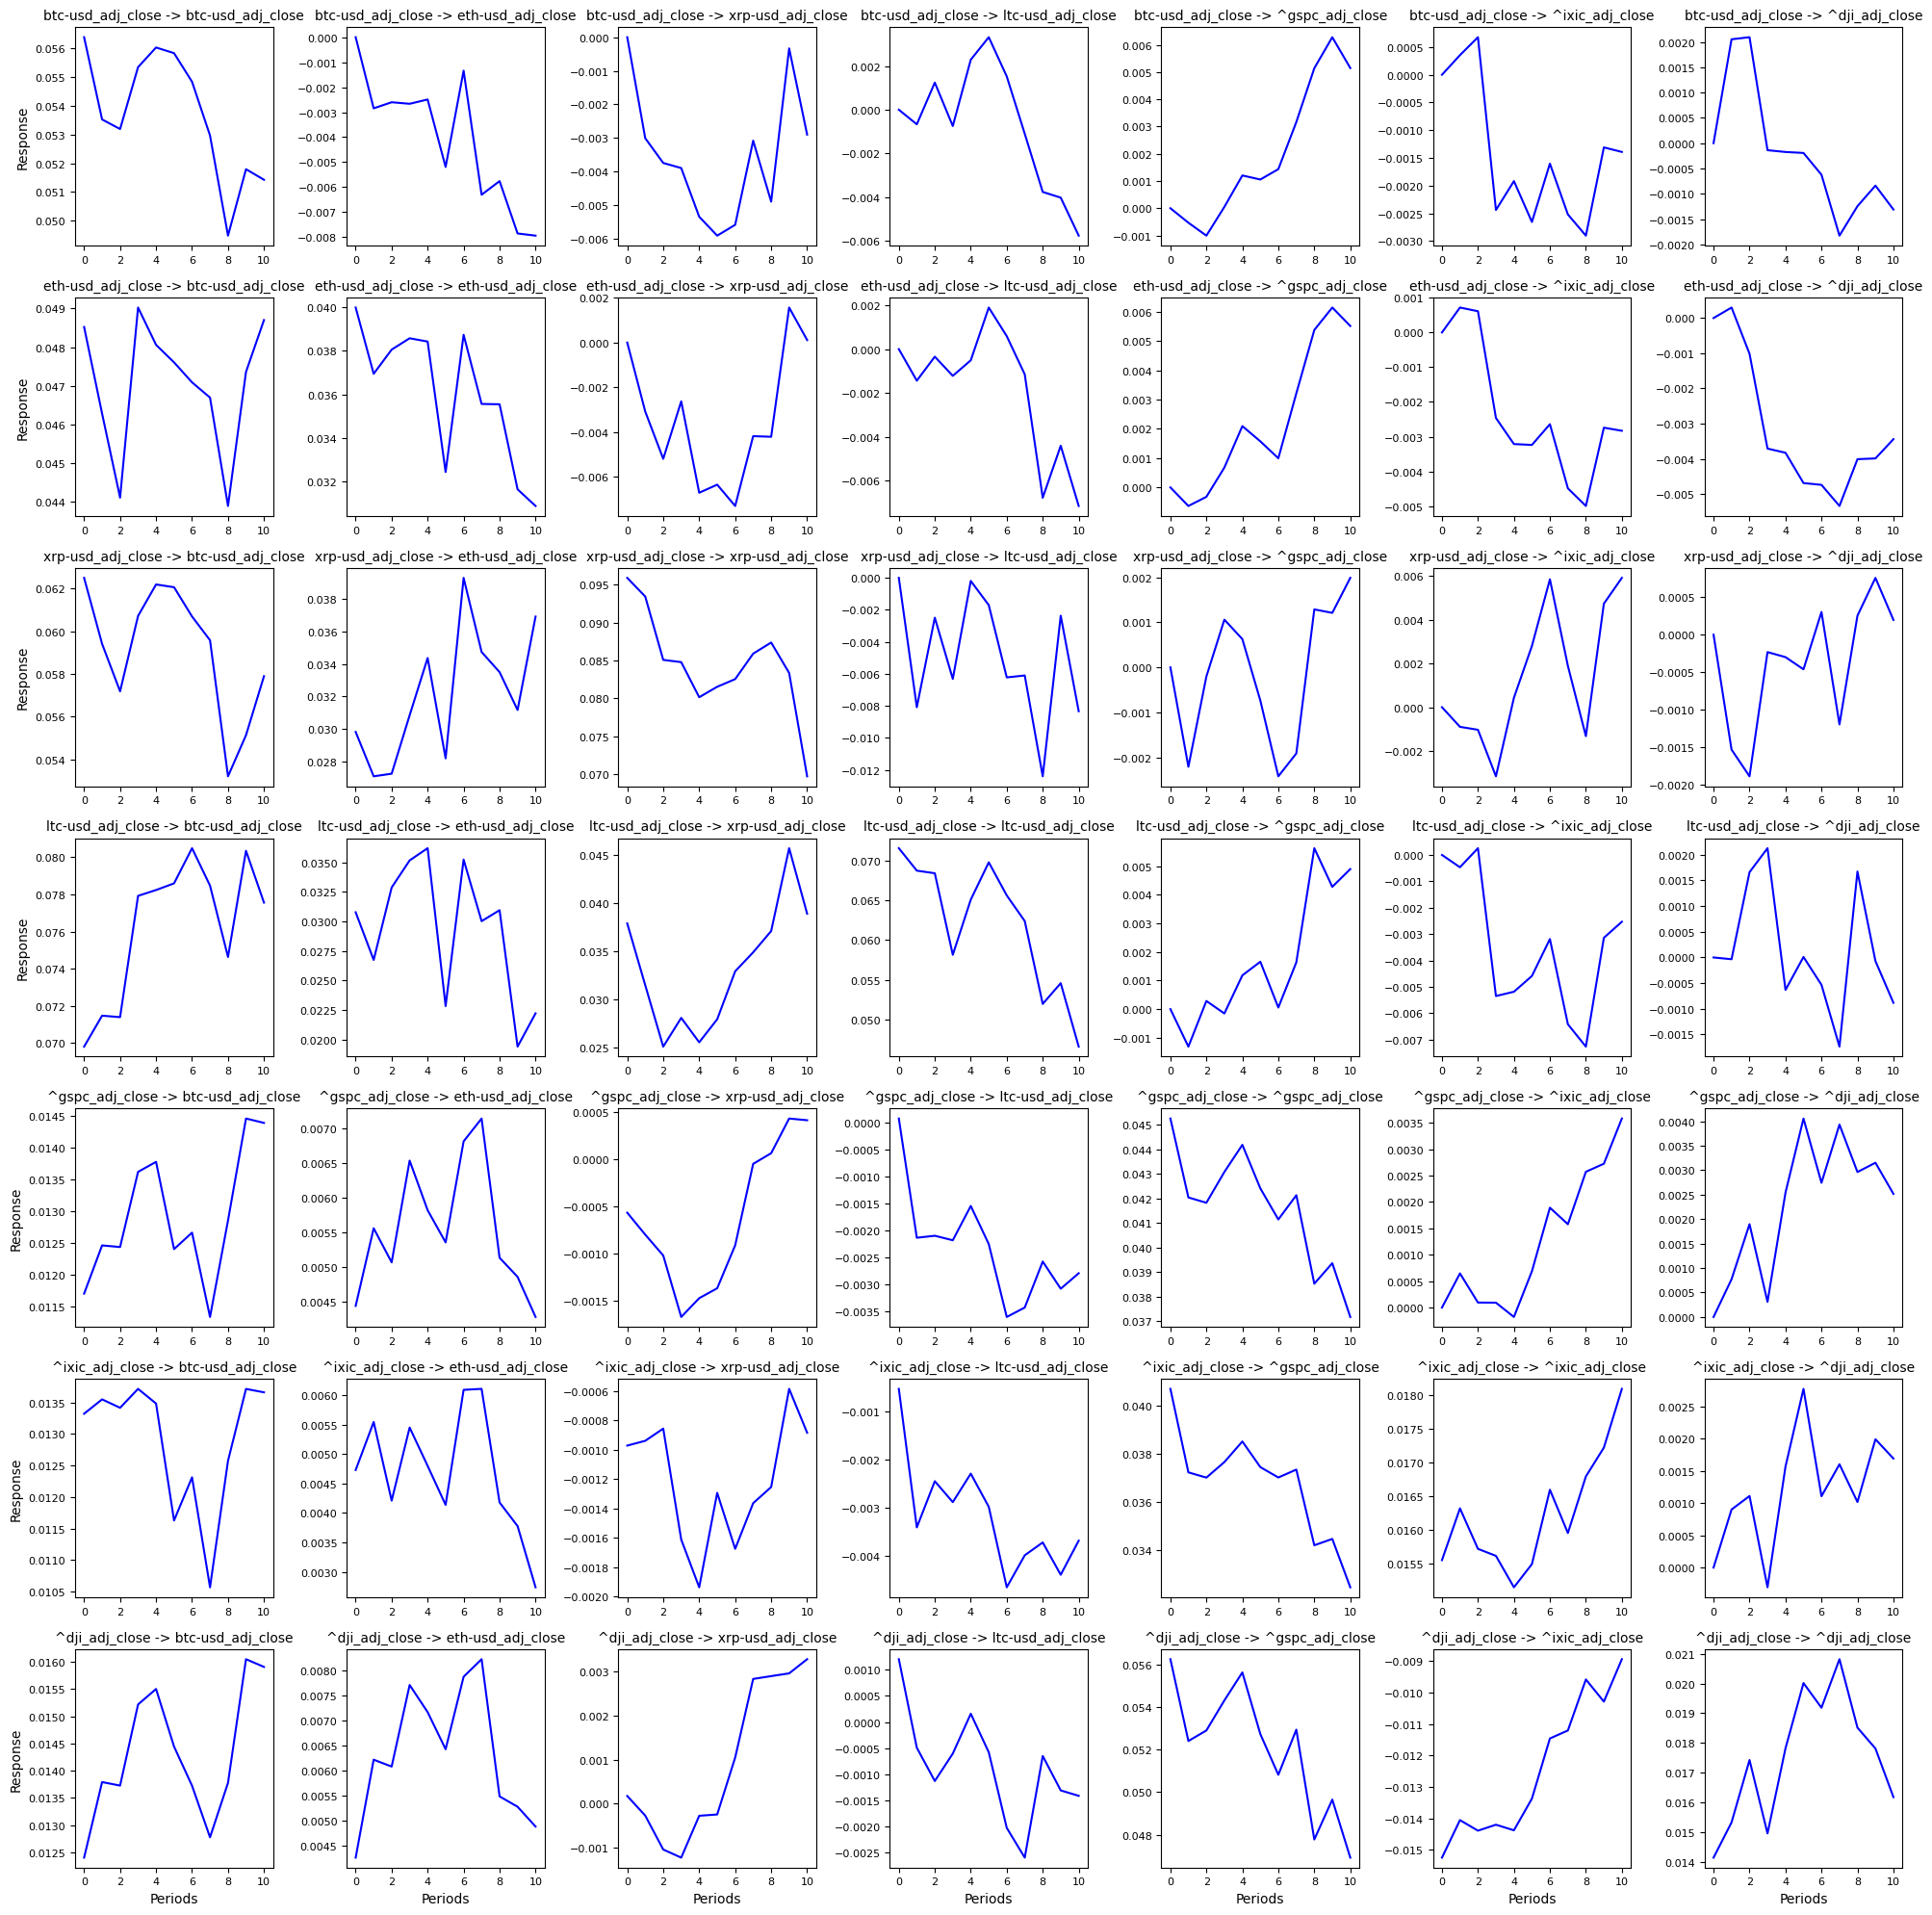

In [46]:
fig, axes = plt.subplots(nrows=7, ncols=7, figsize=(20, 20))
variables = model_data.columns

for i, row_var in enumerate(variables):
    for j, col_var in enumerate(variables):
        if i == j:
            axes[i, j].plot(irf.orth_irfs[:, i, j], 'b')
        else:
            axes[i, j].plot(irf.orth_irfs[:, i, j], 'b')
        axes[i, j].set_title(f"{row_var} -> {col_var}", fontsize=10)
        axes[i, j].tick_params(axis='both', which='major', labelsize=8)
        if i == 6:
            axes[i, j].set_xlabel('Periods', fontsize=10)
        if j == 0:
            axes[i, j].set_ylabel('Response', fontsize=10)

plt.tight_layout()
plt.show()

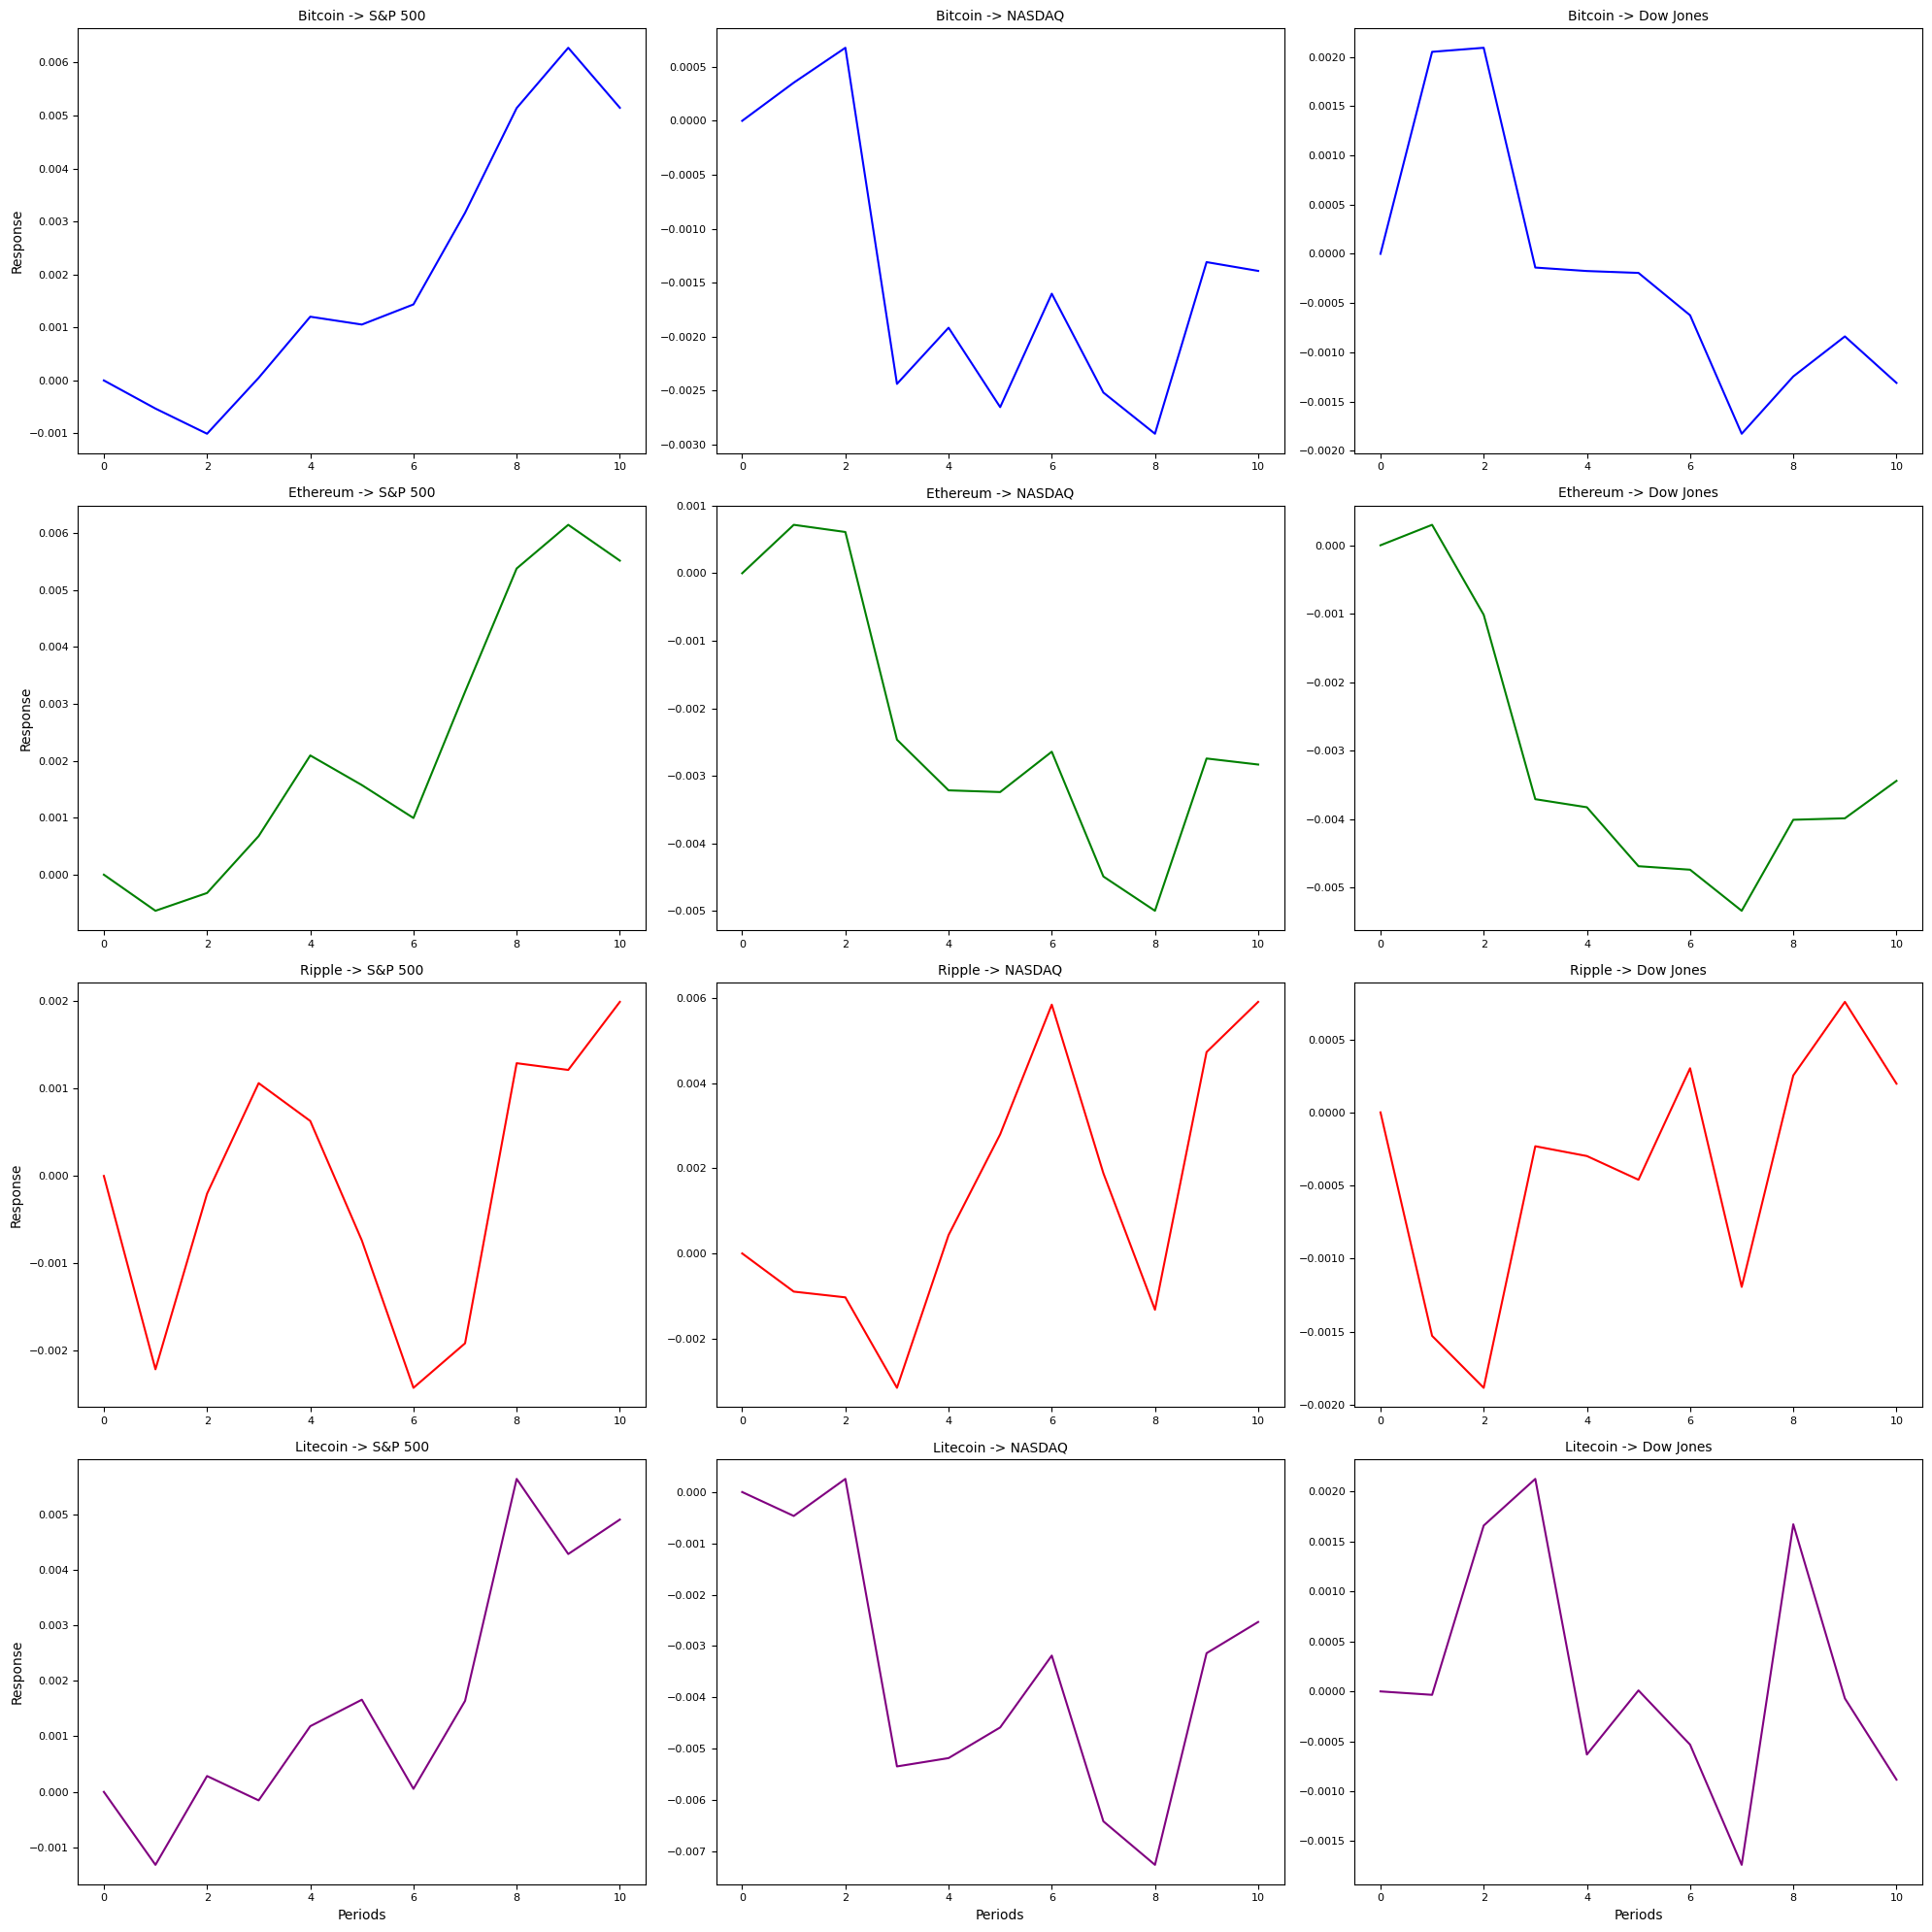

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.api import VAR

# Assuming 'cryptos' and 'stocks' contain the relevant column names for cryptocurrencies and stock indices

# Fill any missing values
model_data = combined_cleaned_data[cryptos + stocks]
model_data = model_data.fillna(method='ffill').fillna(method='bfill')

# Fit the VAR model
model = VAR(model_data)
results = model.fit(maxlags=15, ic='aic')

# Calculate impulse response functions
irf = results.irf(10)  # Adjust the number of periods as needed

# Label mapping dictionary
label_mapping = {
    'btc-usd_adj_close': 'Bitcoin',
    'eth-usd_adj_close': 'Ethereum',
    'xrp-usd_adj_close': 'Ripple',
    'ltc-usd_adj_close': 'Litecoin',
    '^gspc_adj_close': 'S&P 500',
    '^ixic_adj_close': 'NASDAQ',
    '^dji_adj_close': 'Dow Jones'
}

# Create a list of colors for different lines
colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta']

# Plot VAR Impulse Response Functions (IRFs)
fig, axes = plt.subplots(nrows=len(cryptos), ncols=len(stocks), figsize=(20, 20))

for i, crypto in enumerate(cryptos):
    for j, stock in enumerate(stocks):
        row_var = label_mapping[crypto]
        col_var = label_mapping[stock]
        color = colors[i % len(colors)]

        axes[i, j].plot(irf.orth_irfs[:, model_data.columns.get_loc(crypto), model_data.columns.get_loc(stock)], color=color)
        axes[i, j].set_title(f"{row_var} -> {col_var}", fontsize=10)
        axes[i, j].tick_params(axis='both', which='major', labelsize=8)
        if i == len(cryptos) - 1:
            axes[i, j].set_xlabel('Periods', fontsize=10)
        if j == 0:
            axes[i, j].set_ylabel('Response', fontsize=10)

plt.tight_layout()
plt.show()

### DCC-GARCH Model

In [49]:
returns = model_data.pct_change().dropna()

In [50]:
# Define a function to fit univariate GARCH models and extract standardized residuals
def fit_garch_models(returns):
    garch_models = {}
    for column in returns.columns:
        model = arch_model(returns[column], vol='Garch', p=1, q=1)
        garch_models[column] = model.fit(disp="off")
    standardized_residuals = pd.DataFrame({col: garch_models[col].std_resid for col in returns.columns})
    return standardized_residuals

In [51]:
# Define the DCC-GARCH log-likelihood function
def dcc_garch_log_likelihood(params, std_resids):
    t = std_resids.shape[0]
    n = std_resids.shape[1]
    a = params[0]
    b = params[1]

    Q_bar = np.cov(std_resids.T)
    Q_t = Q_bar.copy()
    R_t = np.zeros((t, n, n))

    log_likelihood = 0
    for i in range(t):
        Q_t = (1 - a - b) * Q_bar + a * np.outer(std_resids.iloc[i], std_resids.iloc[i]) + b * Q_t
        D_t = np.diag(np.sqrt(np.diag(Q_t)))
        R_t[i] = np.linalg.inv(D_t) @ Q_t @ np.linalg.inv(D_t)
        log_likelihood += np.log(np.linalg.det(R_t[i])) + std_resids.iloc[i].T @ np.linalg.inv(R_t[i]) @ std_resids.iloc[i]

    return log_likelihood

In [52]:
# Optimize the DCC-GARCH model parameters
def fit_dcc_garch(standardized_residuals):
    initial_params = np.array([0.01, 0.98])
    bounds = [(0, 1), (0, 1)]
    result = minimize(dcc_garch_log_likelihood, initial_params, args=(standardized_residuals,), bounds=bounds)
    return result.x

In [53]:
# Calculate conditional correlations
def calculate_conditional_correlations(params, std_resids):
    a, b = params
    t = std_resids.shape[0]
    n = std_resids.shape[1]
    Q_bar = np.cov(std_resids.T)
    Q_t = Q_bar.copy()
    conditional_correlations = np.zeros((t, n, n))

    for i in range(t):
        Q_t = (1 - a - b) * Q_bar + a * np.outer(std_resids.iloc[i], std_resids.iloc[i]) + b * Q_t
        D_t = np.diag(np.sqrt(np.diag(Q_t)))
        conditional_correlations[i] = np.linalg.inv(D_t) @ Q_t @ np.linalg.inv(D_t)

    return conditional_correlations

In [54]:
# Plot conditional correlations with formatted dates
def plot_conditional_correlations(conditional_correlations_df, cryptos, stocks):
    fig, axes = plt.subplots(len(cryptos), len(stocks), figsize=(20, 15), sharex=True, sharey=True)
    fig.suptitle('DCC-GARCH Time-Varying Correlations between Cryptocurrencies and Stock Indices', fontsize=16)

    for i, crypto in enumerate(cryptos):
        for j, stock in enumerate(stocks):
            ax = axes[i, j]
            pair = (crypto, stock)
            ax.plot(pd.to_datetime(conditional_correlations_df.index), conditional_correlations_df[pair], label=f'{crypto} & {stock}')
            ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)
            ax.set_title(f'{crypto} vs {stock}')
            ax.xaxis.set_major_locator(mdates.YearLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
            ax.set_xlim([pd.to_datetime(conditional_correlations_df.index.min()), pd.to_datetime(conditional_correlations_df.index.max())])
            if i == len(cryptos) - 1:
                ax.set_xlabel('Date')
            if j == 0:
                ax.set_ylabel('Correlation')
            ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


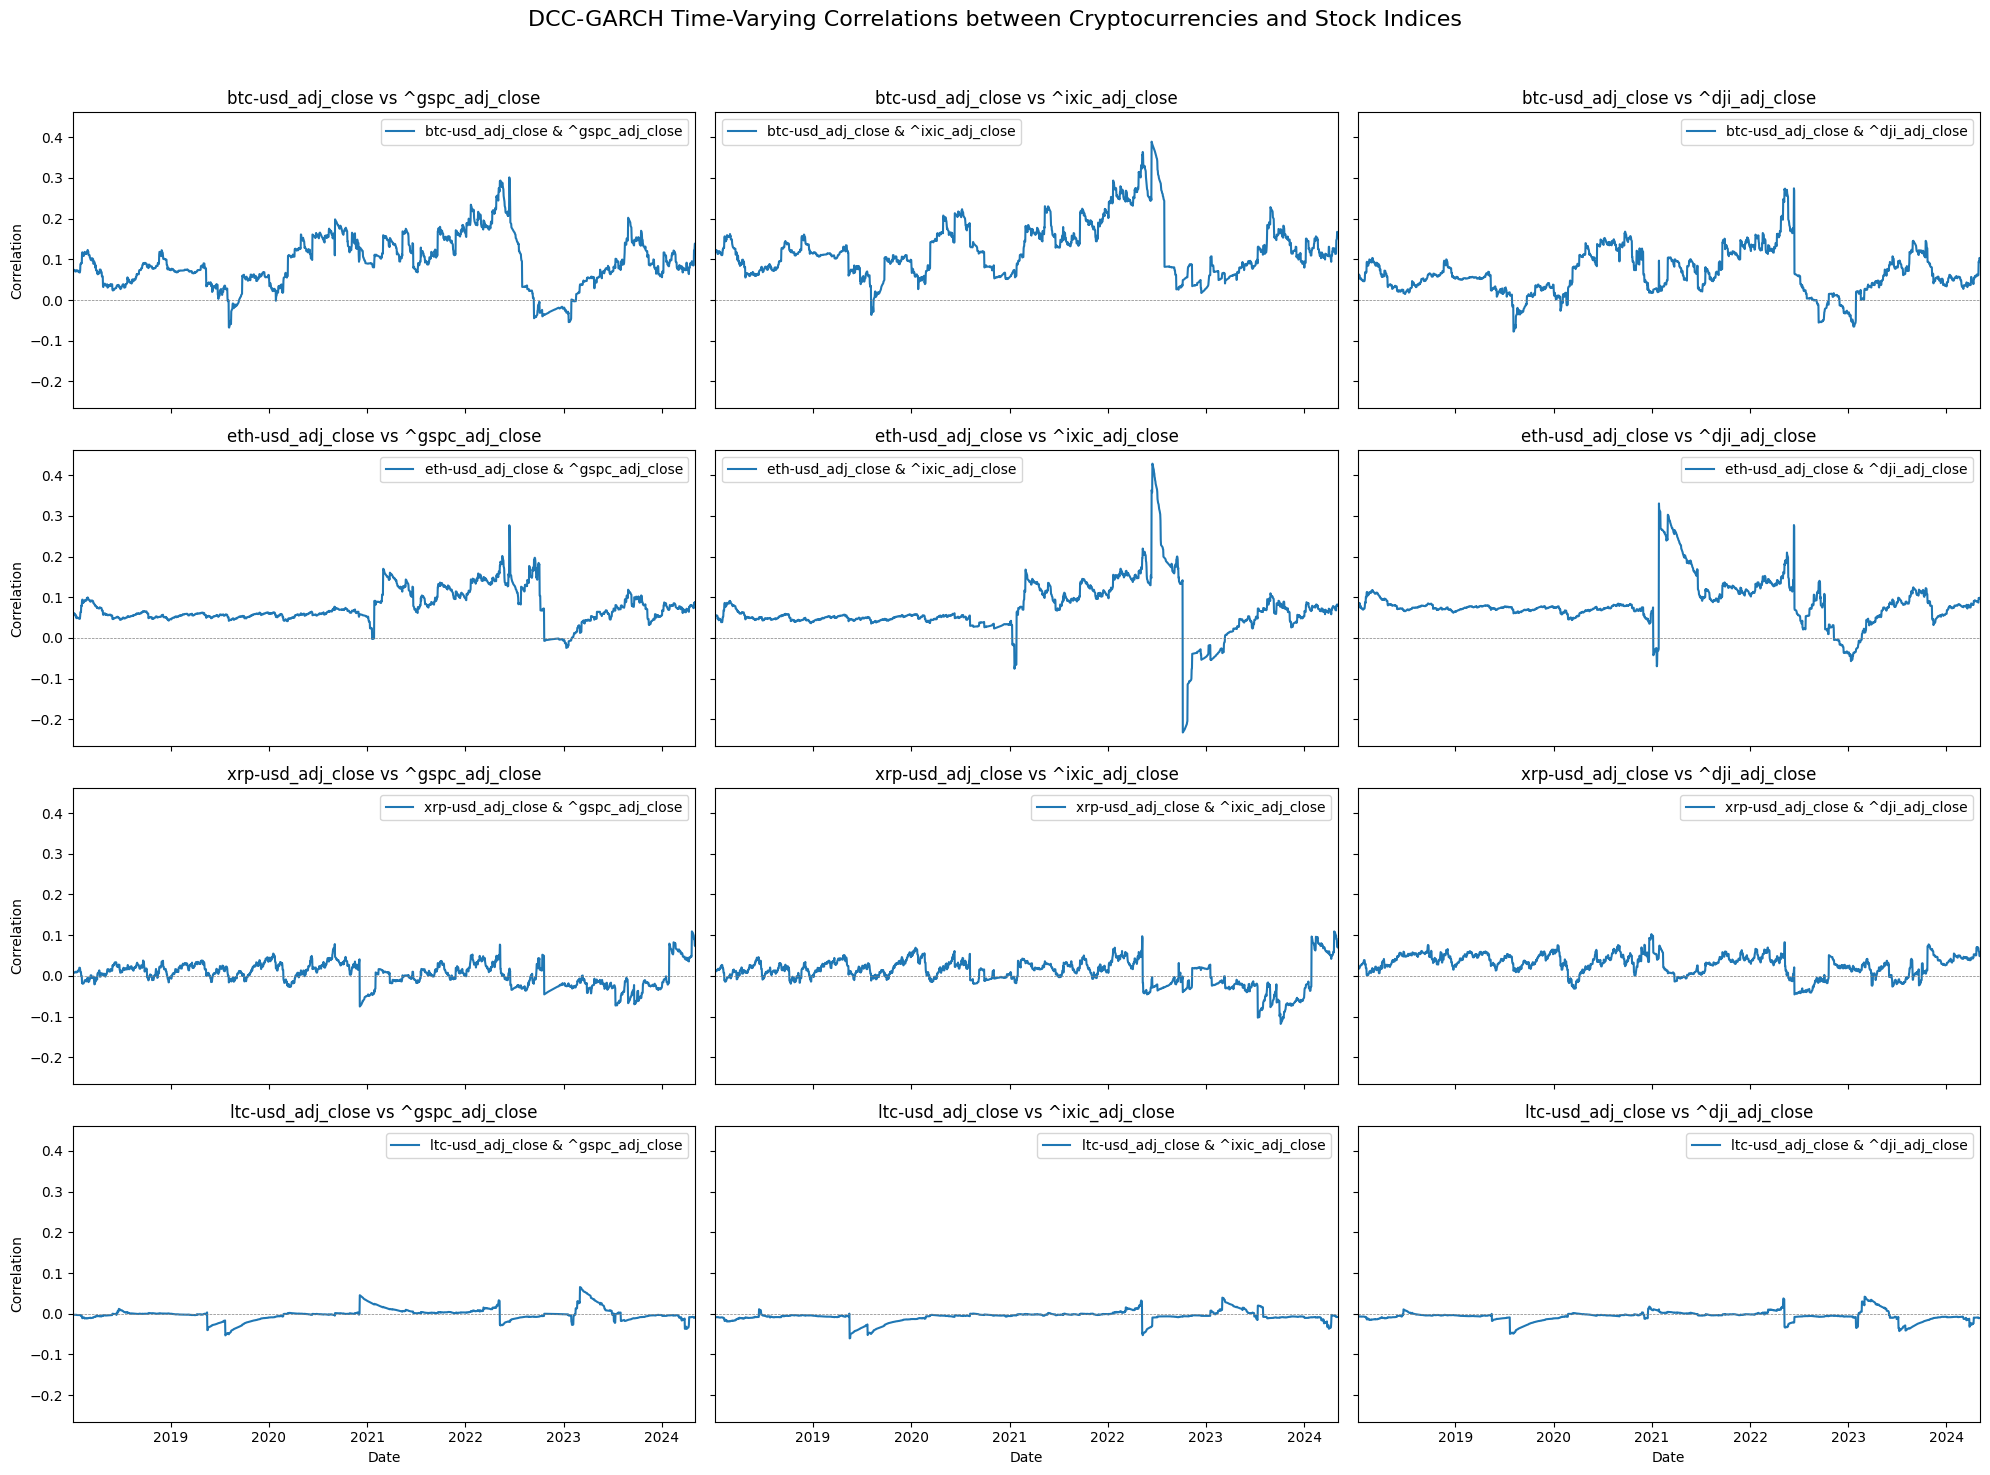

In [55]:
# Fit GARCH models and extract standardized residuals
standardized_residuals = fit_garch_models(returns)

# Fit DCC-GARCH model
dcc_params = fit_dcc_garch(standardized_residuals)

# Calculate conditional correlations
conditional_correlations = calculate_conditional_correlations(dcc_params, standardized_residuals)

# Prepare conditional correlations DataFrame
conditional_correlations_df = pd.DataFrame(index=returns.index, columns=pd.MultiIndex.from_product([returns.columns, returns.columns]))

for i in range(conditional_correlations.shape[0]):
    for j in range(conditional_correlations.shape[1]):
        for k in range(conditional_correlations.shape[2]):
            conditional_correlations_df.iloc[i, conditional_correlations_df.columns.get_loc((returns.columns[j], returns.columns[k]))] = conditional_correlations[i, j, k]

# Plot conditional correlations
plot_conditional_correlations(conditional_correlations_df, cryptos, stocks)

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


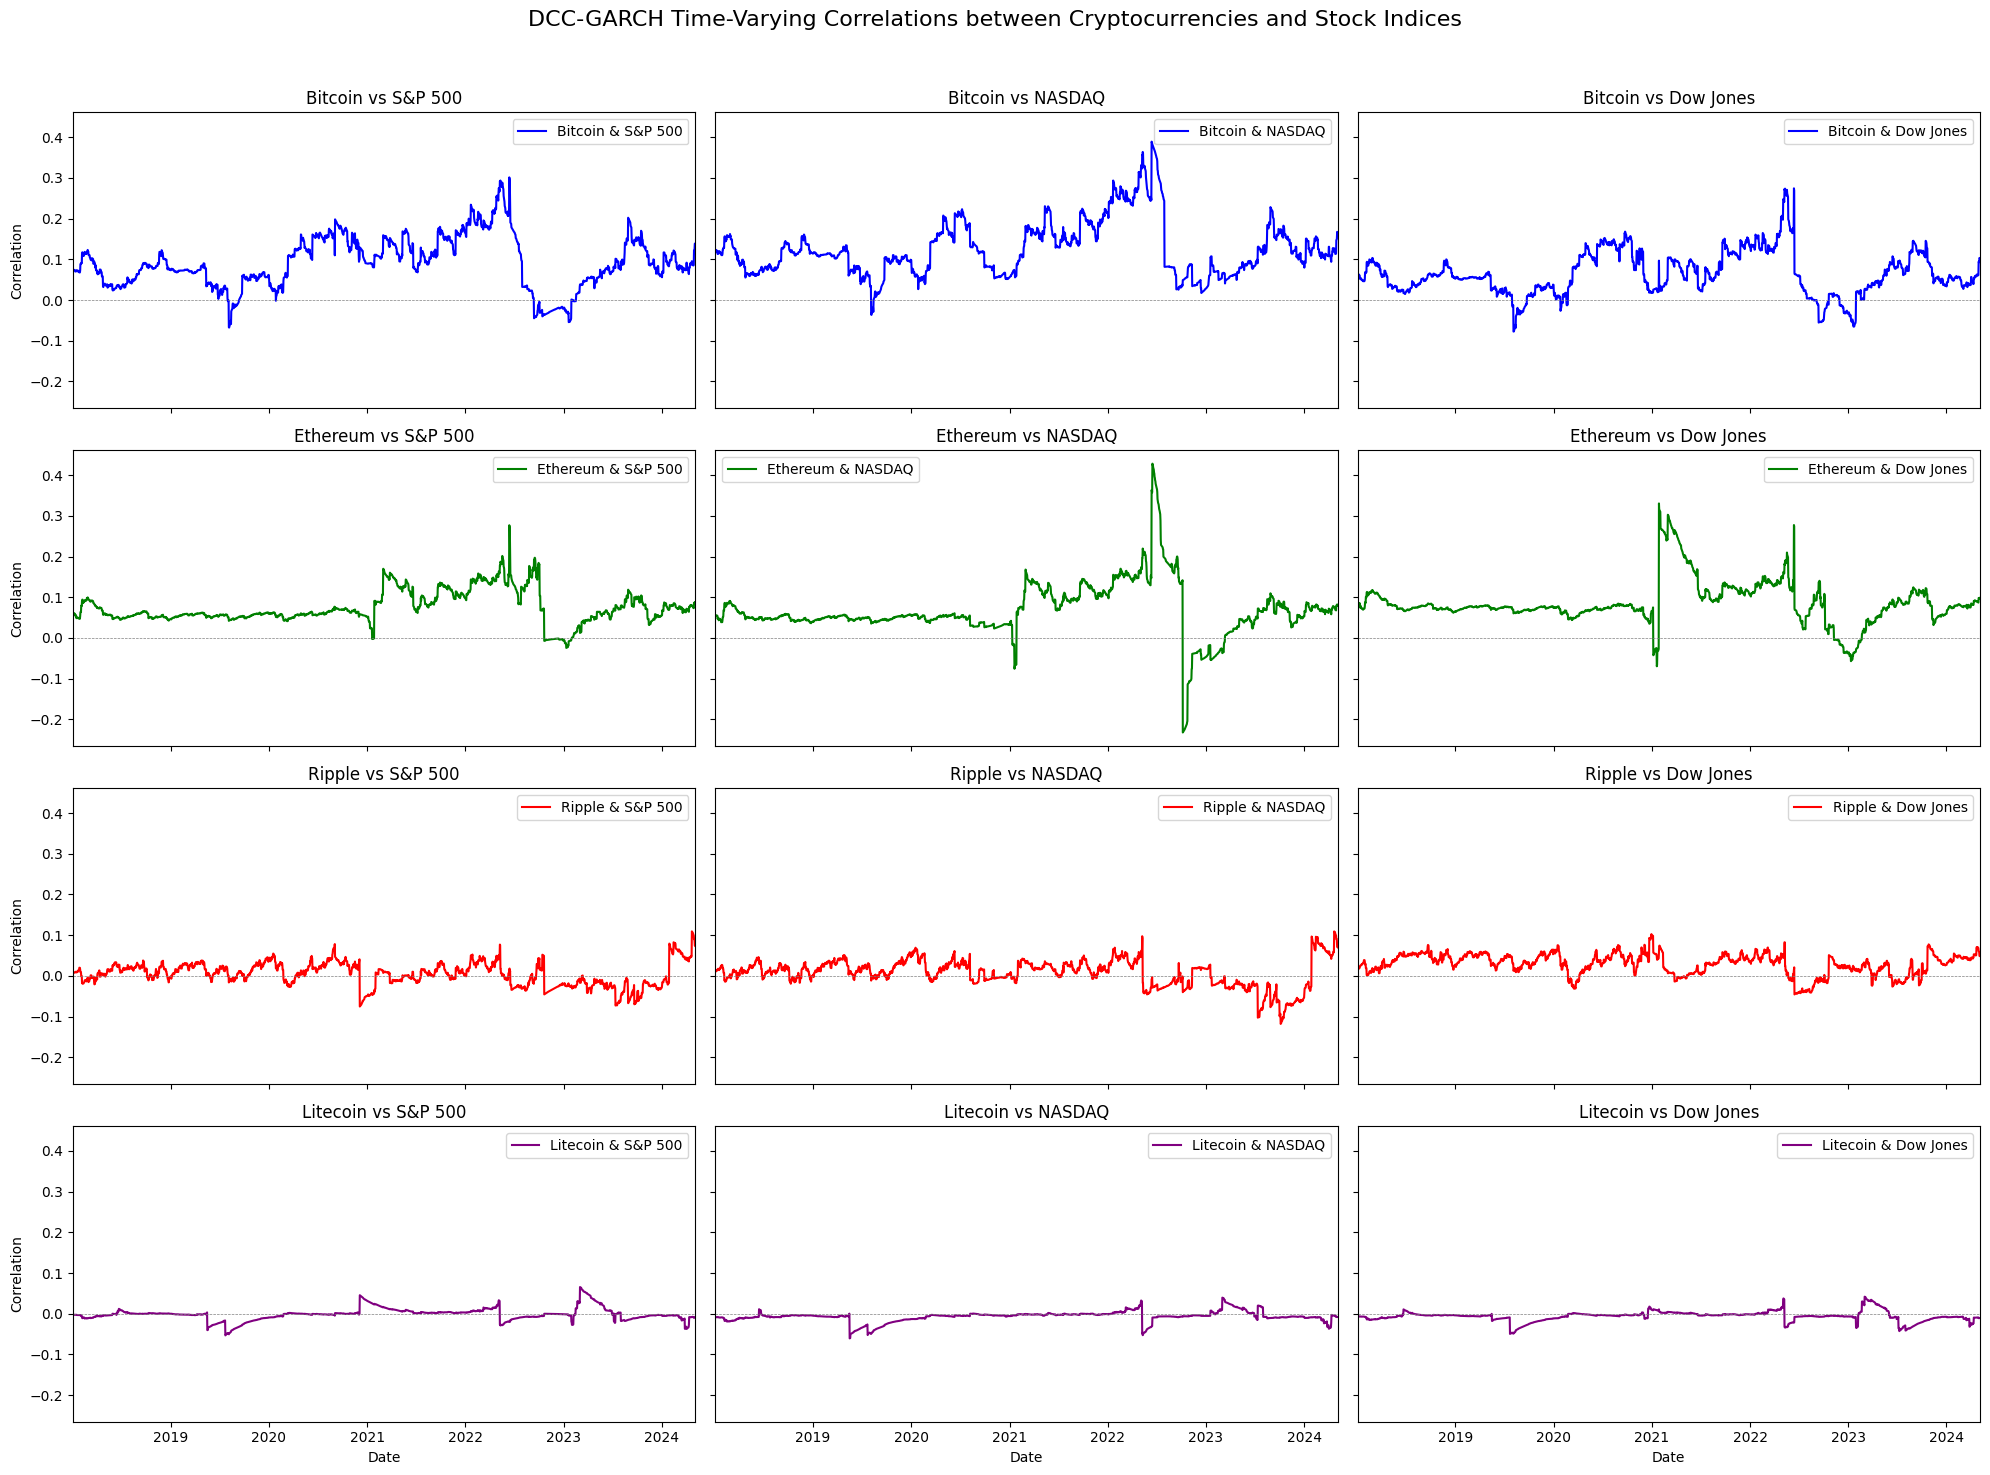

In [56]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Label mapping dictionary
label_mapping = {
    'btc-usd_adj_close': 'Bitcoin',
    'eth-usd_adj_close': 'Ethereum',
    'xrp-usd_adj_close': 'Ripple',
    'ltc-usd_adj_close': 'Litecoin',
    '^gspc_adj_close': 'S&P 500',
    '^ixic_adj_close': 'NASDAQ',
    '^dji_adj_close': 'Dow Jones'
}

# Define a function to plot conditional correlations with better labeling and colors
def plot_conditional_correlations(conditional_correlations_df, cryptos, stocks):
    fig, axes = plt.subplots(len(cryptos), len(stocks), figsize=(20, 15), sharex=True, sharey=True)
    fig.suptitle('DCC-GARCH Time-Varying Correlations between Cryptocurrencies and Stock Indices', fontsize=16)

    # Define a set of colors to use
    colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta']

    for i, crypto in enumerate(cryptos):
        for j, stock in enumerate(stocks):
            ax = axes[i, j]
            pair = (crypto, stock)
            crypto_label = label_mapping[crypto]
            stock_label = label_mapping[stock]
            ax.plot(pd.to_datetime(conditional_correlations_df.index), conditional_correlations_df[pair], label=f'{crypto_label} & {stock_label}', color=colors[i % len(colors)])
            ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)
            ax.set_title(f'{crypto_label} vs {stock_label}')
            ax.xaxis.set_major_locator(mdates.YearLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
            ax.set_xlim([pd.to_datetime(conditional_correlations_df.index.min()), pd.to_datetime(conditional_correlations_df.index.max())])
            if i == len(cryptos) - 1:
                ax.set_xlabel('Date')
            if j == 0:
                ax.set_ylabel('Correlation')
            ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Fit GARCH models and extract standardized residuals
standardized_residuals = fit_garch_models(returns)

# Fit DCC-GARCH model
dcc_params = fit_dcc_garch(standardized_residuals)

# Calculate conditional correlations
conditional_correlations = calculate_conditional_correlations(dcc_params, standardized_residuals)

# Prepare conditional correlations DataFrame
conditional_correlations_df = pd.DataFrame(index=returns.index, columns=pd.MultiIndex.from_product([returns.columns, returns.columns]))

for i in range(conditional_correlations.shape[0]):
    for j in range(conditional_correlations.shape[1]):
        for k in range(conditional_correlations.shape[2]):
            conditional_correlations_df.iloc[i, conditional_correlations_df.columns.get_loc((returns.columns[j], returns.columns[k]))] = conditional_correlations[i, j, k]

# Plot conditional correlations
plot_conditional_correlations(conditional_correlations_df, cryptos, stocks)

### Impact of macroindicators combined with crypto features

In [57]:
# Create interaction terms
for crypto in cryptos:
    for macro in macro_indicators:
        combined_cleaned_data[f'{crypto}_{macro}_interaction'] = combined_cleaned_data[crypto] * combined_cleaned_data[macro]

In [58]:
# Function to build and evaluate regression models
def build_regression_model(data, target, features):
    X = data[features]
    y = data[target]

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Fit the Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f'RMSE: {rmse}')
    print(f'R-squared: {r2}')

    # Plotting the results
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # Plot actual vs predicted values with a line of best fit
    sns.scatterplot(x=y_test, y=y_pred, ax=axs[0], alpha=0.5)
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axs[0], lw=2, label='Line of Best Fit')
    axs[0].set_xlabel('Actual')
    axs[0].set_ylabel('Predicted')
    axs[0].set_title(f'Actual vs Predicted for {target}')
    axs[0].legend()

    # Plot residuals with KDE
    residuals = y_test - y_pred
    sns.histplot(residuals, kde=True, bins=30, ax=axs[1])
    axs[1].set_xlabel('Residuals')
    axs[1].set_ylabel('Frequency')
    axs[1].set_title(f'Residuals Distribution for {target}')
    plt.tight_layout()
    plt.show()

    return model


Regression Model for ^gspc_adj_close
RMSE: 0.06420817578586094
R-squared: 0.9957448248998361


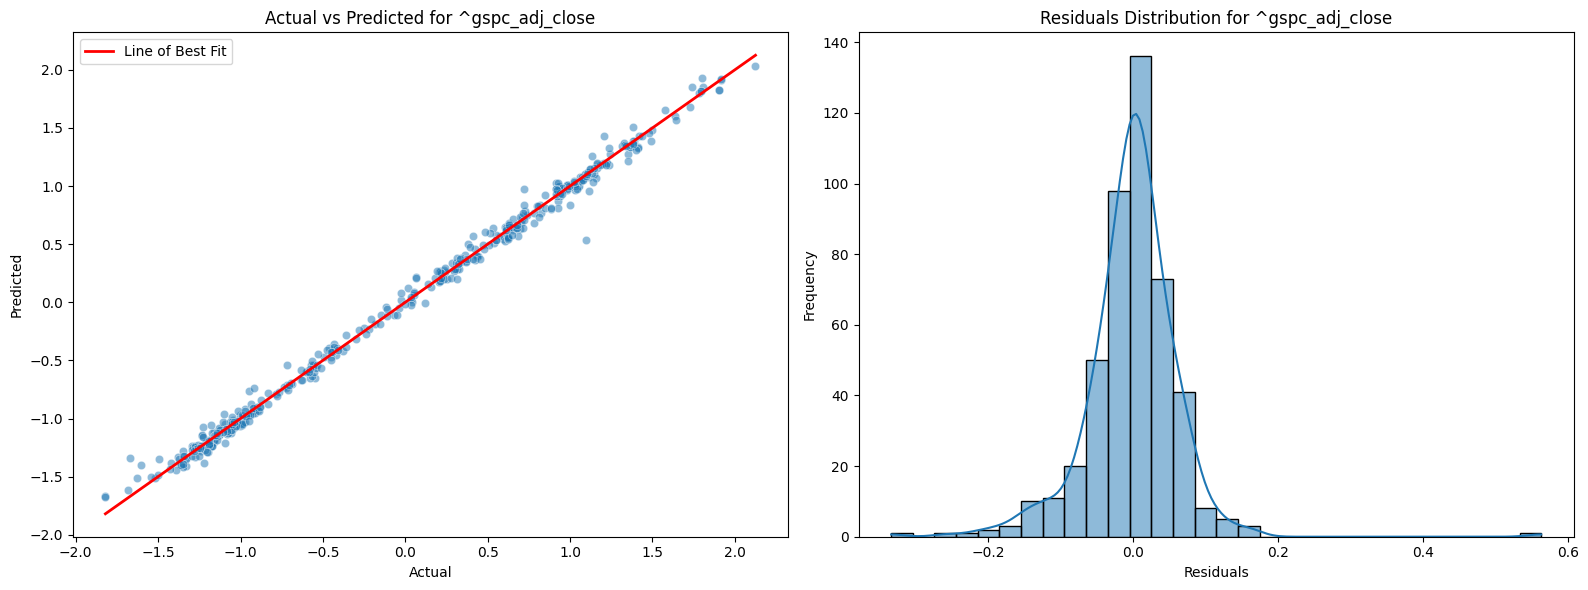


Regression Model for ^ixic_adj_close
RMSE: 0.05824614600655172
R-squared: 0.9965297332770012


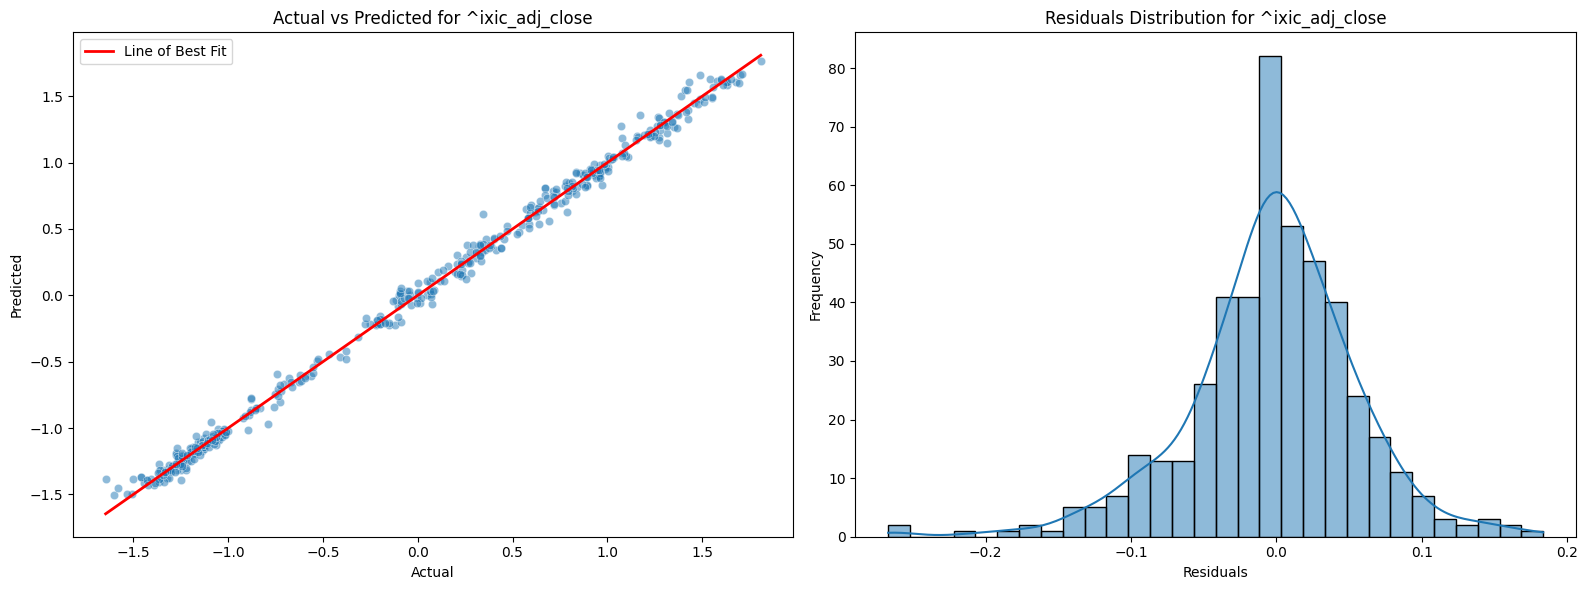


Regression Model for ^dji_adj_close
RMSE: 0.08141943349427268
R-squared: 0.9931567266928183


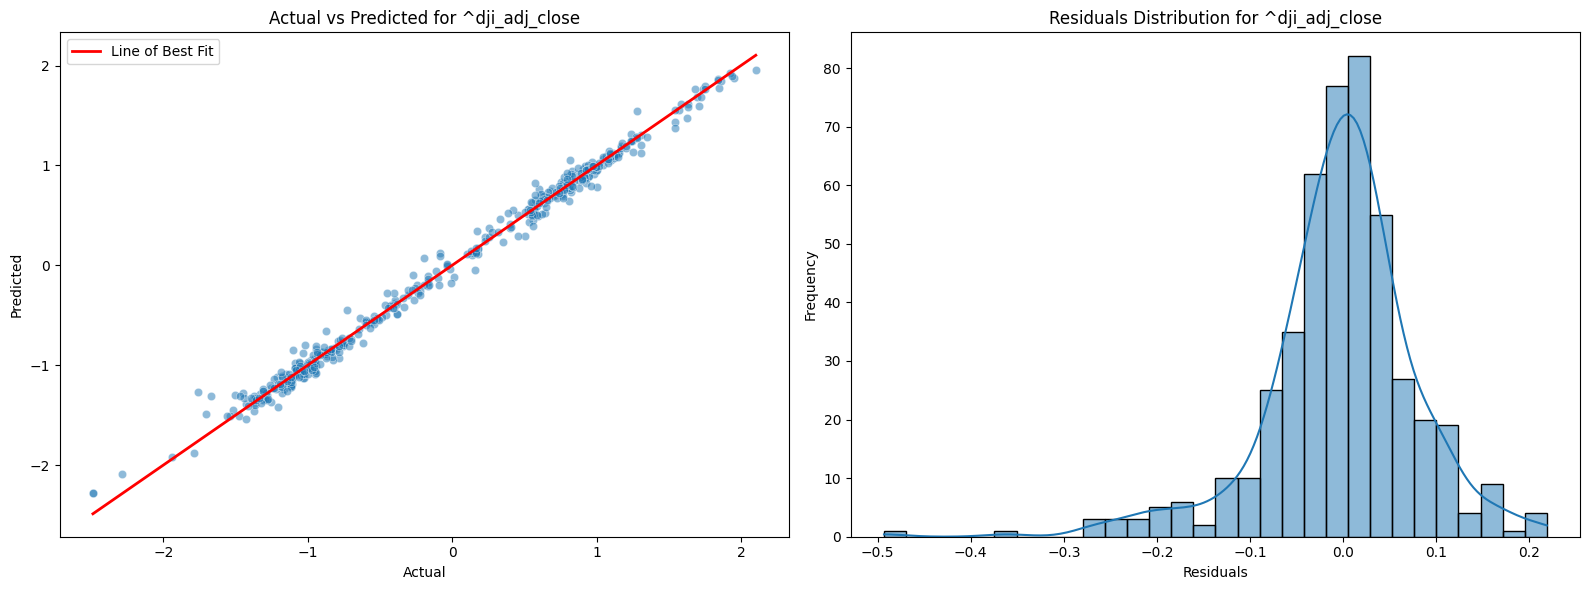

In [59]:
# Define the features including interaction terms
features = macro_indicators + cryptos + [f'{crypto}_{macro}_interaction' for crypto in cryptos for macro in macro_indicators]

# Build and evaluate models for each stock market index
for stock in stocks:
    print(f'\nRegression Model for {stock}')
    model = build_regression_model(combined_cleaned_data, stock, features)

### Feature Engineering

In [60]:
features = ['eth-usd_adj_close', 'consumer_price_index', 'federal_funds_rate', 'gdp', '^ixic_adj_close']
df_features = combined_cleaned_data[features]

In [61]:
df_features

,eth-usd_adj_close,consumer_price_index,federal_funds_rate,gdp,^ixic_adj_close
Date,,,,,
2018-01-01,-0.493618,-1.186903,-0.342827,-1.244929,-1.414758
2018-01-02,-0.398076,-1.186903,-0.342827,-1.244929,-1.414758
2018-01-03,-0.331184,-1.186903,-0.342827,-1.244929,-1.394590
2018-01-04,-0.315629,-1.186903,-0.342827,-1.244929,-1.390331
2018-01-05,-0.301275,-1.186903,-0.342827,-1.244929,-1.370156
...,...,...,...,...,...
2024-05-01,1.383973,1.796605,1.761470,1.820866,1.543057
2024-05-02,1.399683,1.796605,1.761470,1.820866,1.624059
2024-05-03,1.498276,1.796605,1.761470,1.820866,1.732543


In [62]:
def create_lagged_features(data, column, lags):
    for lag in lags:
        data[f'{column}_lag_{lag}'] = data[column].shift(lag)
    return data

In [63]:
# Create lagged features for 'adj_close_btc'
btc_X = create_lagged_features(df_features, 'eth-usd_adj_close', [1, 3, 7])
btc_X.dropna(inplace=True)

btc_X.head()

,eth-usd_adj_close,consumer_price_index,federal_funds_rate,gdp,^ixic_adj_close,eth-usd_adj_close_lag_1,eth-usd_adj_close_lag_3,eth-usd_adj_close_lag_7
Date,,,,,,,,
2018-01-08,-0.172398,-1.186903,-0.342827,-1.244929,-1.362991,-0.168433,-0.301275,-0.493618
2018-01-09,-0.043180,-1.186903,-0.342827,-1.244929,-1.360862,-0.172398,-0.263708,-0.398076
2018-01-10,-0.080713,-1.186903,-0.342827,-1.244929,-1.364305,-0.043180,-0.168433,-0.331184
2018-01-11,-0.166929,-1.186903,-0.342827,-1.244929,-1.344282,-0.080713,-0.172398,-0.315629
2018-01-12,-0.065860,-1.186903,-0.342827,-1.244929,-1.327330,-0.166929,-0.043180,-0.301275


In [64]:
# Calculate Moving Averages and RSI for Bitcoin prices
df_features['MA_7_btc'] = df_features['eth-usd_adj_close'].rolling(window=7).mean()
df_features['MA_21_btc'] = df_features['eth-usd_adj_close'].rolling(window=21).mean()

In [65]:
def compute_rsi(data, window):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

In [66]:
df_features['RSI_14_btc'] = compute_rsi(df_features['eth-usd_adj_close'], 14)
df_features.dropna(inplace=True)

df_features.head()

,eth-usd_adj_close,consumer_price_index,federal_funds_rate,gdp,^ixic_adj_close,eth-usd_adj_close_lag_1,eth-usd_adj_close_lag_3,eth-usd_adj_close_lag_7,MA_7_btc,MA_21_btc,RSI_14_btc
Date,,,,,,,,,,,
2018-01-28,-0.089096,-1.186903,-0.342827,-1.244929,-1.243152,-0.207828,-0.251445,-0.256957,-0.236754,-0.175296,43.502930
2018-01-29,-0.143489,-1.186903,-0.342827,-1.244929,-1.256657,-0.089096,-0.252180,-0.296540,-0.214890,-0.173919,44.033600
2018-01-30,-0.238541,-1.186903,-0.342827,-1.244929,-1.278683,-0.143489,-0.207828,-0.311094,-0.204525,-0.183222,51.102208
2018-01-31,-0.198223,-1.186903,-0.342827,-1.244929,-1.275587,-0.238541,-0.089096,-0.249095,-0.197258,-0.188818,56.512855
2018-02-01,-0.267887,-1.155847,-0.337458,-1.244929,-1.284400,-0.198223,-0.143489,-0.251445,-0.199606,-0.193625,50.029708


In [67]:
# Calculate rolling standard deviation (volatility) for Bitcoin prices
df_features['Volatility_7_btc'] = df_features['eth-usd_adj_close'].rolling(window=7).std()
df_features['Volatility_21_btc'] = df_features['eth-usd_adj_close'].rolling(window=21).std()
df_features.dropna(inplace=True)

btc_X.head()

,eth-usd_adj_close,consumer_price_index,federal_funds_rate,gdp,^ixic_adj_close,eth-usd_adj_close_lag_1,eth-usd_adj_close_lag_3,eth-usd_adj_close_lag_7,MA_7_btc,MA_21_btc,RSI_14_btc,Volatility_7_btc,Volatility_21_btc
Date,,,,,,,,,,,,,
2018-02-17,-0.321446,-1.155847,-0.337458,-1.244929,-1.334756,-0.347002,-0.364648,-0.418610,-0.383868,-0.360903,50.631278,0.050098,0.119212
2018-02-18,-0.364340,-1.155847,-0.337458,-1.244929,-1.334756,-0.321446,-0.353184,-0.457710,-0.370530,-0.374010,56.192810,0.038171,0.101675
2018-02-19,-0.347297,-1.155847,-0.337458,-1.244929,-1.334756,-0.364340,-0.347002,-0.411524,-0.361354,-0.383715,70.366630,0.034186,0.087279
2018-02-20,-0.388738,-1.155847,-0.337458,-1.244929,-1.336531,-0.347297,-0.321446,-0.431562,-0.355236,-0.390868,59.177868,0.020699,0.080693
2018-02-21,-0.427535,-1.155847,-0.337458,-1.244929,-1.342063,-0.388738,-0.364340,-0.364648,-0.364220,-0.401787,58.201374,0.034506,0.067807


### Model Development

In [68]:
df_features.columns

Index(['eth-usd_adj_close', 'consumer_price_index', 'federal_funds_rate',
       'gdp', '^ixic_adj_close', 'eth-usd_adj_close_lag_1',
       'eth-usd_adj_close_lag_3', 'eth-usd_adj_close_lag_7', 'MA_7_btc',
       'MA_21_btc', 'RSI_14_btc', 'Volatility_7_btc', 'Volatility_21_btc'],
      dtype='object')

In [69]:
features = ['eth-usd_adj_close', 'consumer_price_index', 'federal_funds_rate',
       'gdp', '^ixic_adj_close', 'eth-usd_adj_close_lag_1',
       'eth-usd_adj_close_lag_3', 'eth-usd_adj_close_lag_7', 'MA_7_btc',
       'MA_21_btc', 'RSI_14_btc', 'Volatility_7_btc', 'Volatility_21_btc']

target = '^ixic_adj_close'

In [70]:
X = df_features[features]
y = df_features[target]

In [71]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

In [73]:
def calculate_metrics(y_true, y_pred):

    y_pred = y_pred.flatten()

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # Calculate MAPE
    mape = mean_absolute_percentage_error(y_true, y_pred)

    # Calculate Directional Accuracy
    # Shift the arrays to calculate the difference between consecutive elements
    actual_diff = np.diff(y_true)
    predicted_diff = np.diff(y_pred)

    # Check if the signs of the differences are the same (i.e., both positive or both negative)
    correct_direction = np.sum((actual_diff * predicted_diff) > 0)

    # Directional Accuracy is the ratio of correct direction predictions to total predictions
    directional_accuracy = correct_direction / len(actual_diff)

    return rmse, mape, directional_accuracy

#### Linear Model

In [74]:
lr_model = LinearRegression()
lr_model.fit(X_train_full, y_train_full)

LinearRegression()

In [75]:
y_pred_train = lr_model.predict(X_train_full)
y_pred_test = lr_model.predict(X_test)

In [76]:
lr_rmse_train, lr_mape_train, lr_acc_train = calculate_metrics(y_train_full, y_pred_train)
lr_rmse_test, lr_mape_test, lr_acc_test = calculate_metrics(y_test, y_pred_test)

In [77]:
print(f"Train RMSE: {lr_rmse_train}, MAPE: {lr_mape_train}, Directional Accuracy: {lr_acc_train}")
print(f"Test RMSE: {lr_rmse_test}, MAPE: {lr_mape_test}, Directional Accuracy: {lr_acc_test}")

Train RMSE: 2.8126078008026718e-14, MAPE: 1.4861734706010033e-13, Directional Accuracy: 0.9988980716253444
Test RMSE: 2.998839609668318e-14, MAPE: 9.261646062691365e-14, Directional Accuracy: 1.0


### Random Forest

In [ ]:
rf_model = RandomForestRegressor()

In [ ]:
rf_model.fit(X_train_full, y_train_full)

RandomForestRegressor()

In [ ]:
y_pred_train = rf_model.predict(X_train_full)
y_pred_test = rf_model.predict(X_test)

In [ ]:
rf_rmse_train, rf_mape_train, rf_acc_train = calculate_metrics(y_train_full, y_pred_train)
rf_rmse_test, rf_mape_test, rf_acc_test = calculate_metrics(y_test, y_pred_test)

In [ ]:
print(f"Train RMSE: {rf_rmse_train}, MAPE: {rf_mape_train}, Directional Accuracy: {rf_acc_train}")
print(f"Test RMSE: {rf_rmse_test}, MAPE: {rf_mape_test}, Directional Accuracy: {rf_acc_test}")

Train RMSE: 0.02234092406628333, MAPE: 0.04378873607600672, Directional Accuracy: 0.9922865013774105
Test RMSE: 0.060353206728687894, MAPE: 0.3791673110125826, Directional Accuracy: 0.9735099337748344


In [ ]:
importances = rf_model.feature_importances_
feature_names = X_train_full.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                    Feature  Importance
8                 MA_21_btc    0.818374
1      consumer_price_index    0.140426
7                  MA_7_btc    0.006528
3                       gdp    0.006437
0         btc-usd_adj_close    0.006150
2        federal_funds_rate    0.005642
6   btc-usd_adj_close_lag_7    0.005087
4   btc-usd_adj_close_lag_1    0.003527
11        Volatility_21_btc    0.003154
5   btc-usd_adj_close_lag_3    0.002423
9                RSI_14_btc    0.001298
10         Volatility_7_btc    0.000955


#### Overfitting Validation For Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np
import matplotlib.pyplot as plt

# Assuming you already have X_train_full, y_train_full, X_test, y_test

# Define a function to evaluate performance
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Training performance
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    mape_train = mean_absolute_percentage_error(y_train, y_train_pred)

    # Test performance
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

    return rmse_train, mape_train, rmse_test, mape_test

# Function to monitor overfitting
def monitor_overfitting(hyperparams_list):
    results = []

    for params in hyperparams_list:
        print(f"Evaluating with hyperparameters: {params}")

        rf_model = RandomForestRegressor(
            n_estimators=params.get('n_estimators', 100),
            max_depth=params.get('max_depth', None),
            min_samples_split=params.get('min_samples_split', 2),
            min_samples_leaf=params.get('min_samples_leaf', 1),
            max_features=params.get('max_features', 'sqrt'),  # Use 'sqrt' or 'log2' or None
            random_state=42
        )

        rf_model.fit(X_train_full, y_train_full)

        rmse_train, mape_train, rmse_test, mape_test = evaluate_model(rf_model, X_train_full, y_train_full, X_test, y_test)

        print(f"Train RMSE: {rmse_train:.4f}, Train MAPE: {mape_train:.4f}")
        print(f"Test RMSE: {rmse_test:.4f}, Test MAPE: {mape_test:.4f}")

        results.append({
            'params': params,
            'rmse_train': rmse_train,
            'mape_train': mape_train,
            'rmse_test': rmse_test,
            'mape_test': mape_test
        })

    return results

# Define a list of hyperparameters to evaluate
hyperparams_list = [
    {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'},
    {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt'},
    {'n_estimators': 150, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'},
    # Add more configurations here as needed
]

# Run the comparison
results = monitor_overfitting(hyperparams_list)

Evaluating with hyperparameters: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Train RMSE: 0.0221, Train MAPE: 0.0514
Test RMSE: 0.0565, Test MAPE: 0.4164
Evaluating with hyperparameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt'}
Train RMSE: 0.0543, Train MAPE: 0.1301
Test RMSE: 0.0752, Test MAPE: 0.5760
Evaluating with hyperparameters: {'n_estimators': 150, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}
Train RMSE: 0.0333, Train MAPE: 0.0776
Test RMSE: 0.0618, Test MAPE: 0.4498


                                              params  rmse_train  mape_train  \
0  {'n_estimators': 100, 'max_depth': None, 'min_...    0.022126    0.051373   
1  {'n_estimators': 200, 'max_depth': 10, 'min_sa...    0.054312    0.130142   
2  {'n_estimators': 150, 'max_depth': 15, 'min_sa...    0.033323    0.077556   

   rmse_test  mape_test  
0   0.056524   0.416420  
1   0.075165   0.576024  
2   0.061785   0.449794  


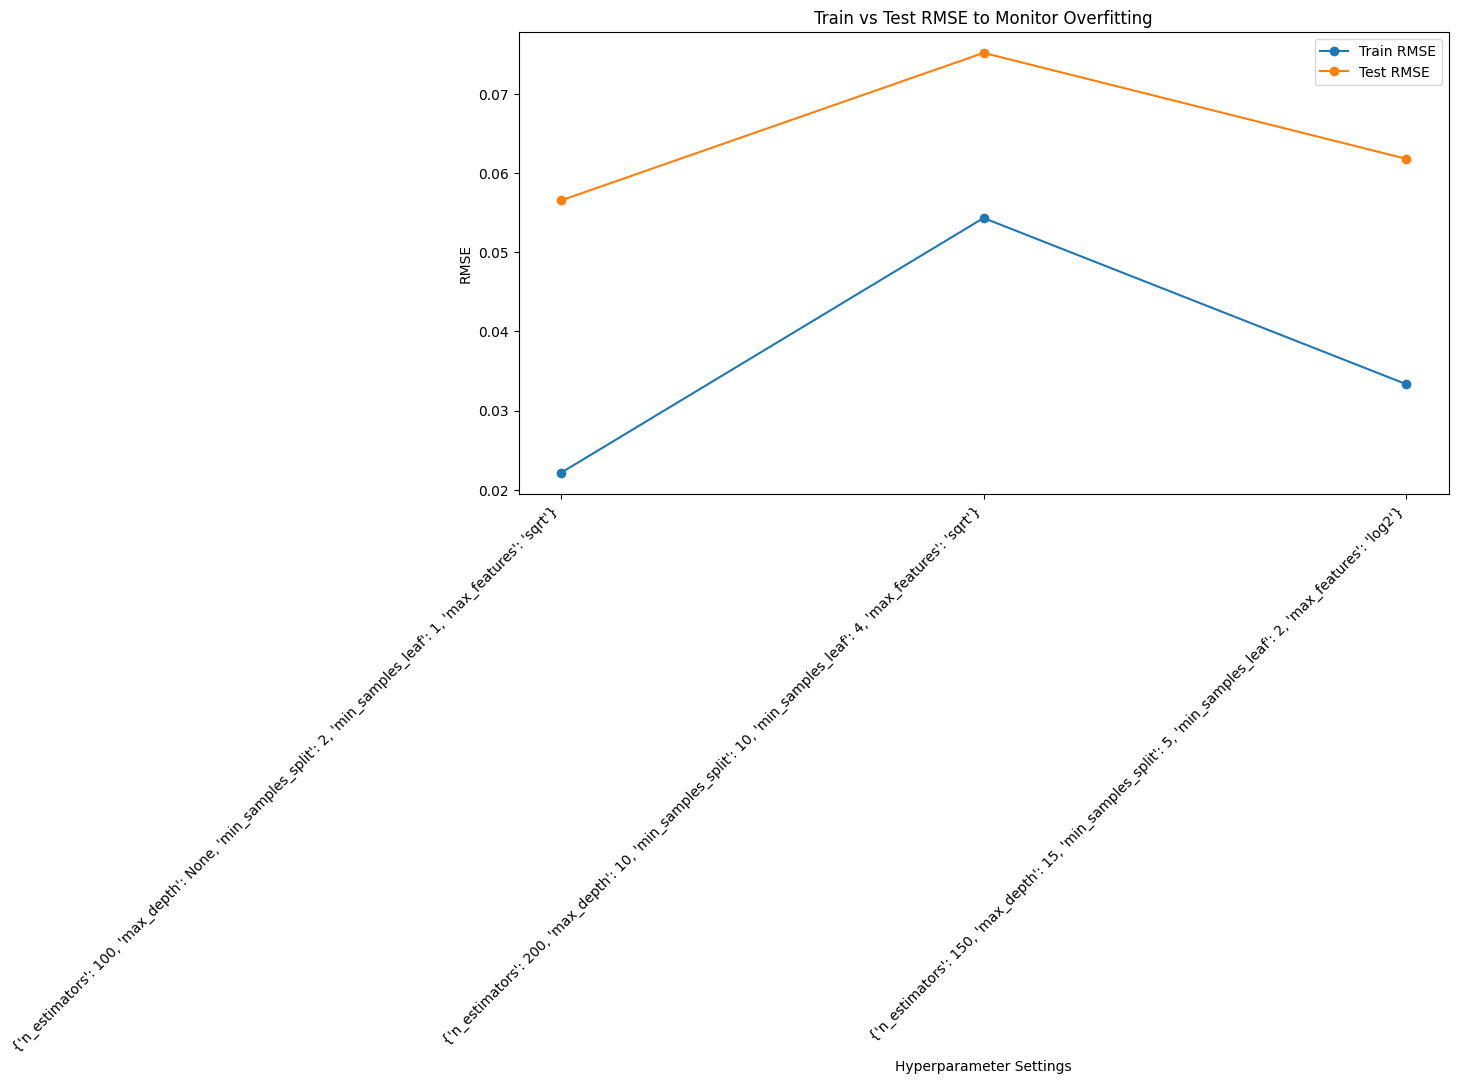

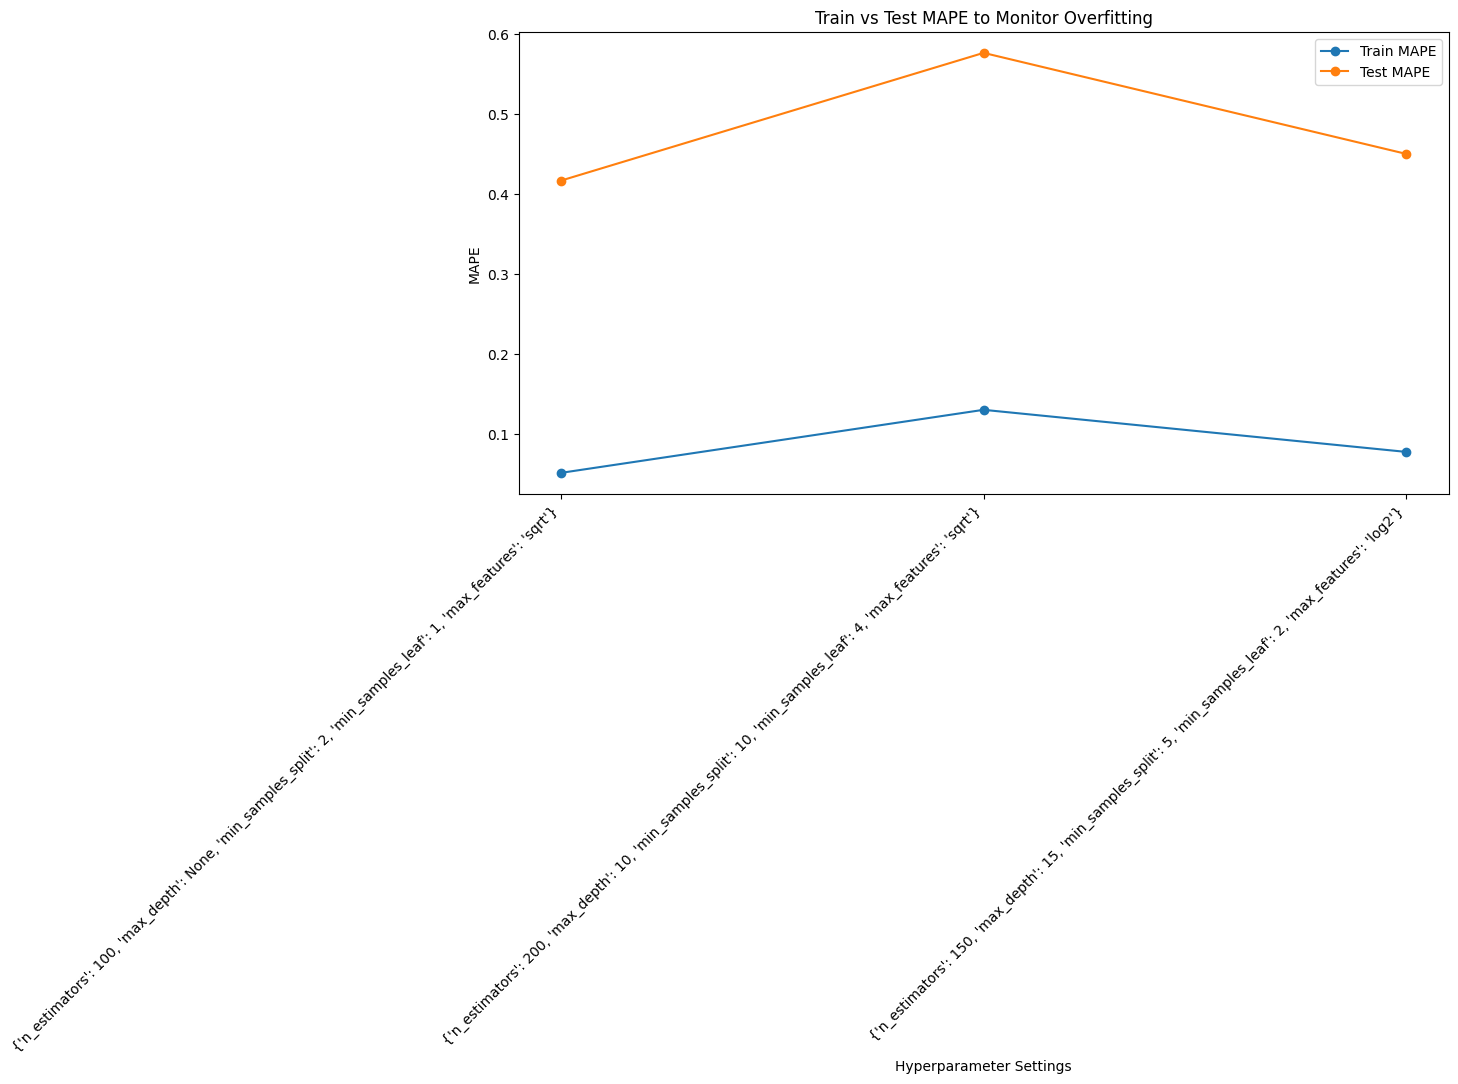

In [ ]:
# Convert results to a format that's easy to visualize
import pandas as pd

results_df = pd.DataFrame(results)

# Print the results for comparison
print(results_df)

# Plot the RMSE for Training vs Test to visualize overfitting
plt.figure(figsize=(12, 6))
plt.plot(results_df['params'].apply(lambda x: str(x)), results_df['rmse_train'], label='Train RMSE', marker='o')
plt.plot(results_df['params'].apply(lambda x: str(x)), results_df['rmse_test'], label='Test RMSE', marker='o')
plt.xticks(rotation=45, ha="right")
plt.xlabel('Hyperparameter Settings')
plt.ylabel('RMSE')
plt.title('Train vs Test RMSE to Monitor Overfitting')
plt.legend()
plt.tight_layout()
plt.show()

# Plot the MAPE for Training vs Test to visualize overfitting
plt.figure(figsize=(12, 6))
plt.plot(results_df['params'].apply(lambda x: str(x)), results_df['mape_train'], label='Train MAPE', marker='o')
plt.plot(results_df['params'].apply(lambda x: str(x)), results_df['mape_test'], label='Test MAPE', marker='o')
plt.xticks(rotation=45, ha="right")
plt.xlabel('Hyperparameter Settings')
plt.ylabel('MAPE')
plt.title('Train vs Test MAPE to Monitor Overfitting')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Initialize the model
rf_model = RandomForestRegressor(random_state=42)

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model
grid_search.fit(X_train_full, y_train_full)

# Get the best parameters and the corresponding score
best_params = grid_search.best_params_
best_score = np.sqrt(-grid_search.best_score_)

print(f"Best Parameters: {best_params}")
print(f"Cross-validated RMSE: {best_score:.4f}")

Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Cross-validated RMSE: 0.0646


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Define your model with the selected hyperparameters
rf_model = RandomForestRegressor(
    n_estimators=150,       # Selected based on previous analysis
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='log2',
    random_state=42
)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(rf_model, X_train_full, y_train_full, cv=5, scoring='neg_mean_squared_error')

# Calculate the average RMSE from the cross-validation scores
cv_rmse = np.sqrt(-cv_scores.mean())
print(f"Cross-validated RMSE: {cv_rmse:.4f}")

Cross-validated RMSE: 0.0690


### LSTM

In [ ]:
X_train_full_lstm = np.reshape(X_train_full.values, (X_train_full.shape[0], X_train_full.shape[1], 1))
X_test_lstm = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_full_lstm.shape[1], 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Train the LSTM model
lstm_model.fit(X_train_full_lstm, y_train_full, epochs=250, batch_size=50)

Epoch 1/250
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.4905
Epoch 2/250
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1849
Epoch 3/250
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1739
Epoch 4/250
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1418
Epoch 5/250
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1268
Epoch 6/250
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.1000
Epoch 7/250
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0873
Epoch 8/250
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0662
Epoch 9/250
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0535
Epoch 10/250
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0447
Epoch 11/250
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0424
Epoch 12/250
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0385
Epoch 13/250
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0299
Epoch 14/250
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0268
Epoch 15/250
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - lo

In [ ]:
# Make predictions on the test set

y_pred_train = lstm_model.predict(X_train_full_lstm)
y_pred_test = lstm_model.predict(X_test_lstm)

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [ ]:
y_train_full.shape, y_pred_train.shape, X_train_full_lstm.shape

((1816,), (1816, 1), (1816, 13, 1))

In [ ]:
lstm_rmse_train, lstm_mape_train, lstm_acc_train = calculate_metrics(y_train_full, y_pred_train)
lstm_rmse_test, lstm_mape_test, lstm_acc_test = calculate_metrics(y_test, y_pred_test)

print(f"LSTM Train RMSE: {lstm_rmse_train}, MAPE: {lstm_mape_train}, Directional Accuracy: {lstm_acc_train}")
print(f"LSTM Test RMSE: {lstm_rmse_test}, MAPE: {lstm_mape_test}, Directional Accuracy: {lstm_acc_test}")

LSTM Train RMSE: 0.0579649684007364, MAPE: 0.29087436116646087, Directional Accuracy: 0.9757575757575757
LSTM Test RMSE: 0.061626746481336536, MAPE: 0.15933434216977324, Directional Accuracy: 0.9646799116997793


## Cross Validation and Hyperparameter Tuning

Using Pytorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, GridSearchCV
import optuna

In [ ]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [ ]:
def objective(trial):
    # Hyperparameter search space
    hidden_size = trial.suggest_int('hidden_size', 32, 256)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])
    num_epochs = trial.suggest_int('num_epochs', 100, 500)

    model = NeuralNetwork(input_size=X_train.shape[1], hidden_size=hidden_size, output_size=1)

    # Select the optimizer
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    criterion = nn.MSELoss()

    # Train the model
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.unsqueeze(1))
            val_loss += loss.item()

    return val_loss / len(val_loader)

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)  # Adjust the number of trials as needed

print("Best hyperparameters: ", study.best_params)

[I 2024-08-14 14:21:20,669] A new study created in memory with name: no-name-76b97294-8d98-4b71-9baf-ebbf6cd32e63
[I 2024-08-14 14:21:30,708] Trial 0 finished with value: 0.0496184956903259 and parameters: {'hidden_size': 87, 'learning_rate': 0.0016906120584018957, 'optimizer': 'SGD', 'num_epochs': 165}. Best is trial 0 with value: 0.0496184956903259.
[I 2024-08-14 14:21:49,716] Trial 1 finished with value: 0.03809168683364987 and parameters: {'hidden_size': 130, 'learning_rate': 4.2296402121612236e-05, 'optimizer': 'RMSprop', 'num_epochs': 336}. Best is trial 1 with value: 0.03809168683364987.
[I 2024-08-14 14:22:04,834] Trial 2 finished with value: 0.024531541826824346 and parameters: {'hidden_size': 98, 'learning_rate': 0.00621072219361294, 'optimizer': 'Adam', 'num_epochs': 247}. Best is trial 2 with value: 0.024531541826824346.
[I 2024-08-14 14:22:16,115] Trial 3 finished with value: 0.036704191099852325 and parameters: {'hidden_size': 192, 'learning_rate': 4.496094063281221e-05, 

Best hyperparameters:  {'hidden_size': 161, 'learning_rate': 0.005004977684632328, 'optimizer': 'Adam', 'num_epochs': 482}


In [ ]:
best_params = study.best_params

best_model = NeuralNetwork(
    input_size=X_train.shape[1],
    hidden_size=best_params['hidden_size'],
    output_size=1
)

# Select the optimizer
if best_params['optimizer'] == 'Adam':
    optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
elif best_params['optimizer'] == 'SGD':
    optimizer = optim.SGD(best_model.parameters(), lr=best_params['learning_rate'])
elif best_params['optimizer'] == 'RMSprop':
    optimizer = optim.RMSprop(best_model.parameters(), lr=best_params['learning_rate'])

criterion = nn.MSELoss()

# Train the model with the best parameters
for epoch in range(best_params['num_epochs']):
    best_model.train()
    for X_batch, y_batch in train_loader:
        outputs = best_model(X_batch)
        loss = criterion(outputs, y_batch.unsqueeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Evaluate the model
best_model.eval()
with torch.no_grad():
    y_train_pred_nn = best_model(X_train_tensor).squeeze().numpy()
    y_test_pred_nn = best_model(X_test_tensor).squeeze().numpy()

train_rmse_nn, train_mape_nn = calculate_metrics(y_train, y_train_pred_nn)
test_rmse_nn, test_mape_nn = calculate_metrics(y_test, y_test_pred_nn)

print(f"Neural Network Train RMSE: {train_rmse_nn}, Train MAPE: {train_mape_nn}")
print(f"Neural Network Test RMSE: {test_rmse_nn}, Test MAPE: {test_mape_nn}")

Neural Network Train RMSE: 0.12295927414115522, Train MAPE: 0.3069859508729405
Neural Network Test RMSE: 0.13911546467268307, Test MAPE: 1.4808007677753579


Improving overfitting for neural network

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)  # Apply dropout after the first layer
        out = self.fc2(out)
        return out

In [ ]:
def objective(trial):
    # Hyperparameter search space
    hidden_size = trial.suggest_int('hidden_size', 32, 256)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])
    num_epochs = trial.suggest_int('num_epochs', 10, 50)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)

    model = NeuralNetwork(input_size=X_train.shape[1], hidden_size=hidden_size, output_size=1, dropout_rate=dropout_rate)

    # Select the optimizer
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    criterion = nn.MSELoss()

    # Train the model
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.unsqueeze(1))
            val_loss += loss.item()

    return val_loss / len(val_loader)

### Adding Dropouts

In [ ]:
# Define the neural network with dropout
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

# Objective function with dropout hyperparameter tuning
def objective(trial):
    hidden_size = trial.suggest_int('hidden_size', 32, 256)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])
    num_epochs = trial.suggest_int('num_epochs', 10, 600)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)

    model = NeuralNetwork(input_size=X_train.shape[1], hidden_size=hidden_size, output_size=1, dropout_rate=dropout_rate)

    # Select the optimizer
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    criterion = nn.MSELoss()

    # Train the model
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.unsqueeze(1))
            val_loss += loss.item()

    return val_loss / len(val_loader)

# Optimize with Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Use the best hyperparameters to train the final model
best_params = study.best_params
best_model = NeuralNetwork(
    input_size=X_train.shape[1],
    hidden_size=best_params['hidden_size'],
    output_size=1,
    dropout_rate=best_params['dropout_rate']
)

# Choose the optimizer based on the best parameters
if best_params['optimizer'] == 'Adam':
    optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
elif best_params['optimizer'] == 'SGD':
    optimizer = optim.SGD(best_model.parameters(), lr=best_params['learning_rate'])
elif best_params['optimizer'] == 'RMSprop':
    optimizer = optim.RMSprop(best_model.parameters(), lr=best_params['learning_rate'])

criterion = nn.MSELoss()

# Train the model with the best parameters
for epoch in range(best_params['num_epochs']):
    best_model.train()
    for X_batch, y_batch in train_loader:
        outputs = best_model(X_batch)
        loss = criterion(outputs, y_batch.unsqueeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Evaluate the model
best_model.eval()
with torch.no_grad():
    y_train_pred_nn = best_model(X_train_tensor).squeeze().numpy()
    y_test_pred_nn = best_model(X_test_tensor).squeeze().numpy()

train_rmse_nn, train_mape_nn, train_acc_nn = calculate_metrics(y_train, y_train_pred_nn)
test_rmse_nn, test_mape_nn, test_acc_nn = calculate_metrics(y_test, y_test_pred_nn)

print(f"Neural Network Train RMSE: {train_rmse_nn}, Train MAPE: {train_mape_nn}, Train Directional Accuracy: {train_acc_nn}")
print(f"Neural Network Test RMSE: {test_rmse_nn}, Test MAPE: {test_mape_nn}, Test Directional Accuracy: {test_acc_nn}")

[I 2024-08-15 08:07:03,714] A new study created in memory with name: no-name-f32794f5-cbad-4a79-b2dd-11ad1e762985
[I 2024-08-15 08:07:18,018] Trial 0 finished with value: 0.03269211423272888 and parameters: {'hidden_size': 44, 'learning_rate': 0.0019258105905925033, 'optimizer': 'Adam', 'num_epochs': 148, 'dropout_rate': 0.15525548706113237}. Best is trial 0 with value: 0.03269211423272888.
[I 2024-08-15 08:07:48,758] Trial 1 finished with value: 0.05424081459641457 and parameters: {'hidden_size': 48, 'learning_rate': 0.0004164583584569782, 'optimizer': 'SGD', 'num_epochs': 452, 'dropout_rate': 0.22118716989079507}. Best is trial 0 with value: 0.03269211423272888.
[I 2024-08-15 08:08:29,755] Trial 2 finished with value: 0.027562984824180604 and parameters: {'hidden_size': 185, 'learning_rate': 0.00015732601599851792, 'optimizer': 'RMSprop', 'num_epochs': 551, 'dropout_rate': 0.3334204047690713}. Best is trial 2 with value: 0.027562984824180604.
[I 2024-08-15 08:09:12,370] Trial 3 finis

Neural Network Train RMSE: 0.12527609719256, Train MAPE: 0.31999204329052433, Train Directional Accuracy: 0.9610580455547392
Neural Network Test RMSE: 0.1335503012374991, Test MAPE: 1.8381611172341035, Test Directional Accuracy: 0.9403973509933775


In [ ]:
# Objective function with L2 regularization (weight decay)
def objective(trial):
    hidden_size = trial.suggest_int('hidden_size', 32, 256)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])
    num_epochs = trial.suggest_int('num_epochs', 10, 600)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-3)

    model = NeuralNetwork(input_size=X_train.shape[1], hidden_size=hidden_size, output_size=1, dropout_rate=dropout_rate)

    # Select the optimizer with weight decay
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    criterion = nn.MSELoss()

    # Train the model
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.unsqueeze(1))
            val_loss += loss.item()

    return val_loss / len(val_loader)

# Optimize with Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Use the best hyperparameters to train the final model
best_params = study.best_params
best_model = NeuralNetwork(
    input_size=X_train.shape[1],
    hidden_size=best_params['hidden_size'],
    output_size=1,
    dropout_rate=best_params['dropout_rate']
)

# Choose the optimizer based on the best parameters
if best_params['optimizer'] == 'Adam':
    optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])
elif best_params['optimizer'] == 'SGD':
    optimizer = optim.SGD(best_model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])
elif best_params['optimizer'] == 'RMSprop':
    optimizer = optim.RMSprop(best_model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])

criterion = nn.MSELoss()

# Train the model with the best parameters
for epoch in range(best_params['num_epochs']):
    best_model.train()
    for X_batch, y_batch in train_loader:
        outputs = best_model(X_batch)
        loss = criterion(outputs, y_batch.unsqueeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Evaluate the model
best_model.eval()
with torch.no_grad():
    y_train_pred_nn = best_model(X_train_tensor).squeeze().numpy()
    y_test_pred_nn = best_model(X_test_tensor).squeeze().numpy()

train_rmse_nn, train_mape_nn, train_acc_nn = calculate_metrics(y_train, y_train_pred_nn)
test_rmse_nn, test_mape_nn, test_acc_nn = calculate_metrics(y_test, y_test_pred_nn)

print(f"Neural Network Train RMSE: {train_rmse_nn}, Train MAPE: {train_mape_nn}, Train Directional Accuracy: {train_acc_nn}")
print(f"Neural Network Test RMSE: {test_rmse_nn}, Test MAPE: {test_mape_nn}, Test Directional Accuracy: {test_acc_nn}")

[I 2024-08-15 08:34:01,375] A new study created in memory with name: no-name-8fd968dd-3281-4ed9-b020-63232f398e80
[I 2024-08-15 08:34:37,004] Trial 0 finished with value: 0.04359619605044524 and parameters: {'hidden_size': 51, 'learning_rate': 0.0009135170254145353, 'optimizer': 'Adam', 'num_epochs': 402, 'dropout_rate': 0.34845593256865104, 'weight_decay': 0.0008360367126491018}. Best is trial 0 with value: 0.04359619605044524.
[I 2024-08-15 08:35:03,486] Trial 1 finished with value: 0.024400834242502847 and parameters: {'hidden_size': 136, 'learning_rate': 0.00040814603045586647, 'optimizer': 'RMSprop', 'num_epochs': 276, 'dropout_rate': 0.13394046812834956, 'weight_decay': 0.00013171417641395837}. Best is trial 1 with value: 0.024400834242502847.
[I 2024-08-15 08:35:19,517] Trial 2 finished with value: 0.04457944165915251 and parameters: {'hidden_size': 110, 'learning_rate': 7.873525017281059e-05, 'optimizer': 'Adam', 'num_epochs': 193, 'dropout_rate': 0.33853979516320987, 'weight_d

Neural Network Train RMSE: 0.13229809931266626, Train MAPE: 0.3031527798558689, Train Directional Accuracy: 0.9559147685525349
Neural Network Test RMSE: 0.14143431051989638, Test MAPE: 1.83814298882168, Test Directional Accuracy: 0.9359823399558499


In [ ]:
# Define early stopping training function
def train_with_early_stopping(model, train_loader, val_loader, num_epochs, learning_rate, patience=5):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch.unsqueeze(1))
                val_loss += loss.item()

        val_loss /= len(val_loader)

        # Check for early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            model.load_state_dict(best_model_state)
            break

    return model

# Training with early stopping
best_model = train_with_early_stopping(best_model, train_loader, val_loader, num_epochs=50, learning_rate=best_params['learning_rate'])

# Evaluate the model
best_model.eval()
with torch.no_grad():
    y_train_pred_nn = best_model(X_train_tensor).squeeze().numpy()
    y_test_pred_nn = best_model(X_test_tensor).squeeze().numpy()

train_rmse_nn, train_mape_nn, train_acc_nn = calculate_metrics(y_train, y_train_pred_nn)
test_rmse_nn, test_mape_nn, test_acc_nn = calculate_metrics(y_test, y_test_pred_nn)

print(f"Neural Network Train RMSE: {train_rmse_nn}, Train MAPE: {train_mape_nn}, Train Directional Accuracy: {train_acc_nn}")
print(f"Neural Network Test RMSE: {test_rmse_nn}, Test MAPE: {test_mape_nn}, Test Directional Accuracy: {test_acc_nn}")

Early stopping triggered
Neural Network Train RMSE: 0.13254301750454647, Train MAPE: 0.30717431065818357, Train Directional Accuracy: 0.9566495224099927
Neural Network Test RMSE: 0.14345475450104922, Test MAPE: 1.6573982762198818, Test Directional Accuracy: 0.9293598233995585


In [ ]:
# Objective function with reduced model complexity
def objective(trial):
    hidden_size = trial.suggest_int('hidden_size', 32, 128)  # Reduced upper limit
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])
    num_epochs = trial.suggest_int('num_epochs', 10, 600)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)

    model = NeuralNetwork(input_size=X_train.shape[1], hidden_size=hidden_size, output_size=1, dropout_rate=dropout_rate)

    # Select the optimizer
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    criterion = nn.MSELoss()

    # Train the model
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.unsqueeze(1))
            val_loss += loss.item()

    return val_loss / len(val_loader)

# Optimize with Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Use the best hyperparameters to train the final model
best_params = study.best_params
best_model = NeuralNetwork(
    input_size=X_train.shape[1],
    hidden_size=best_params['hidden_size'],
    output_size=1,
    dropout_rate=best_params['dropout_rate']
)

# Choose the optimizer based on the best parameters
if best_params['optimizer'] == 'Adam':
    optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
elif best_params['optimizer'] == 'SGD':
    optimizer = optim.SGD(best_model.parameters(), lr=best_params['learning_rate'])
elif best_params['optimizer'] == 'RMSprop':
    optimizer = optim.RMSprop(best_model.parameters(), lr=best_params['learning_rate'])

criterion = nn.MSELoss()

# Train the model with the best parameters
for epoch in range(best_params['num_epochs']):
    best_model.train()
    for X_batch, y_batch in train_loader:
        outputs = best_model(X_batch)
        loss = criterion(outputs, y_batch.unsqueeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Evaluate the model
best_model.eval()
with torch.no_grad():
    y_train_pred_nn = best_model(X_train_tensor).squeeze().numpy()
    y_test_pred_nn = best_model(X_test_tensor).squeeze().numpy()

train_rmse_nn, train_mape_nn, train_acc_nn = calculate_metrics(y_train, y_train_pred_nn)
test_rmse_nn, test_mape_nn, test_acc_nn = calculate_metrics(y_test, y_test_pred_nn)

print(f"Neural Network Train RMSE: {train_rmse_nn}, Train MAPE: {train_mape_nn}, Train Directional Accuracy: {train_acc_nn}")
print(f"Neural Network Test RMSE: {test_rmse_nn}, Test MAPE: {test_mape_nn}, Test Directional Accuracy: {test_acc_nn}")

[I 2024-08-15 09:05:05,607] A new study created in memory with name: no-name-9f35ec27-af56-46c2-b7a9-dccfe342a26e
[I 2024-08-15 09:05:17,032] Trial 0 finished with value: 0.31114751001199087 and parameters: {'hidden_size': 107, 'learning_rate': 0.002466823186176381, 'optimizer': 'SGD', 'num_epochs': 172, 'dropout_rate': 0.29525339225718883}. Best is trial 0 with value: 0.31114751001199087.
[I 2024-08-15 09:05:44,934] Trial 1 finished with value: 0.08189893923699856 and parameters: {'hidden_size': 59, 'learning_rate': 0.0002183413015255566, 'optimizer': 'SGD', 'num_epochs': 451, 'dropout_rate': 0.40965293214857346}. Best is trial 1 with value: 0.08189893923699856.
[I 2024-08-15 09:06:17,220] Trial 2 finished with value: 0.059808960432807604 and parameters: {'hidden_size': 40, 'learning_rate': 2.9838755320769337e-05, 'optimizer': 'Adam', 'num_epochs': 392, 'dropout_rate': 0.1954531847926005}. Best is trial 2 with value: 0.059808960432807604.
[I 2024-08-15 09:06:32,321] Trial 3 finished w

Neural Network Train RMSE: 0.16979169063396268, Train MAPE: 0.41736251265427365, Train Directional Accuracy: 0.9448934606906686
Neural Network Test RMSE: 0.1778714939607731, Test MAPE: 2.372528977888292, Test Directional Accuracy: 0.9271523178807947


In [ ]:
# Define the neural network with batch normalization and dropout
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)  # Batch normalization
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

# Objective function with batch normalization
def objective(trial):
    hidden_size = trial.suggest_int('hidden_size', 32, 256)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])
    num_epochs = trial.suggest_int('num_epochs', 10, 600)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)

    model = NeuralNetwork(input_size=X_train.shape[1], hidden_size=hidden_size, output_size=1, dropout_rate=dropout_rate)

    # Select the optimizer
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    criterion = nn.MSELoss()

    # Train the model
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.unsqueeze(1))
            val_loss += loss.item()

    return val_loss / len(val_loader)

# Optimize with Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Use the best hyperparameters to train the final model
best_params = study.best_params
best_model = NeuralNetwork(
    input_size=X_train.shape[1],
    hidden_size=best_params['hidden_size'],
    output_size=1,
    dropout_rate=best_params['dropout_rate']
)

# Choose the optimizer based on the best parameters
if best_params['optimizer'] == 'Adam':
    optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
elif best_params['optimizer'] == 'SGD':
    optimizer = optim.SGD(best_model.parameters(), lr=best_params['learning_rate'])
elif best_params['optimizer'] == 'RMSprop':
    optimizer = optim.RMSprop(best_model.parameters(), lr=best_params['learning_rate'])

criterion = nn.MSELoss()

# Train the model with the best parameters
for epoch in range(best_params['num_epochs']):
    best_model.train()
    for X_batch, y_batch in train_loader:
        outputs = best_model(X_batch)
        loss = criterion(outputs, y_batch.unsqueeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Evaluate the model
best_model.eval()
with torch.no_grad():
    y_train_pred_nn = best_model(X_train_tensor).squeeze().numpy()
    y_test_pred_nn = best_model(X_test_tensor).squeeze().numpy()

train_rmse_nn, train_mape_nn, train_acc_nn = calculate_metrics(y_train, y_train_pred_nn)
test_rmse_nn, test_mape_nn, test_acc_nn = calculate_metrics(y_test, y_test_pred_nn)

print(f"Neural Network Train RMSE: {train_rmse_nn}, Train MAPE: {train_mape_nn}, Train Directional Accuracy: {train_acc_nn}")
print(f"Neural Network Test RMSE: {test_rmse_nn}, Test MAPE: {test_mape_nn}, Test Directional Accuracy: {test_acc_nn}")

[I 2024-08-15 00:43:47,138] A new study created in memory with name: no-name-77223649-4cc7-4788-9e34-3be7301224d0
[I 2024-08-15 00:45:27,252] Trial 0 finished with value: 0.06185940491656462 and parameters: {'hidden_size': 144, 'learning_rate': 2.1991764598248552e-05, 'optimizer': 'SGD', 'num_epochs': 600, 'dropout_rate': 0.2418373713353625}. Best is trial 0 with value: 0.06185940491656462.
[I 2024-08-15 00:46:43,482] Trial 1 finished with value: 0.028657236509025096 and parameters: {'hidden_size': 217, 'learning_rate': 0.0001281666489994462, 'optimizer': 'RMSprop', 'num_epochs': 396, 'dropout_rate': 0.13880486803512518}. Best is trial 1 with value: 0.028657236509025096.
[I 2024-08-15 00:47:26,387] Trial 2 finished with value: 0.033154824872811635 and parameters: {'hidden_size': 111, 'learning_rate': 0.0010569798892911715, 'optimizer': 'Adam', 'num_epochs': 422, 'dropout_rate': 0.37749542238549827}. Best is trial 1 with value: 0.028657236509025096.
[I 2024-08-15 00:47:40,432] Trial 3 f

Neural Network Train RMSE: 0.15887097561733024, Train MAPE: 0.39192506658498216, Train Directional Accuracy: 0.9463629684055841
Neural Network Test RMSE: 0.15945848386605618, Test MAPE: 1.9390253200203622, Test Directional Accuracy: 0.9249448123620309


Model Selection

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from keras.models import Sequential
from keras.layers import Dense, LSTM
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import optuna

# Assuming X_train, y_train, X_val, y_val, X_test, y_test are already defined

# Define a function to evaluate performance including directional accuracy
def calculate_metrics(y_true, y_pred):
    y_true = np.array(y_true).flatten()  # Flattening in case y_true is not 1D
    y_pred = np.array(y_pred).flatten()  # Flattening in case y_pred is not 1D

    if len(y_true) != len(y_pred):
        min_len = min(len(y_true), len(y_pred))
        y_true = y_true[:min_len]
        y_pred = y_pred[:min_len]

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)

    # Directional Accuracy Calculation
    directional_accuracy = np.mean(np.sign(np.diff(y_true)) == np.sign(np.diff(y_pred)))

    return rmse, mape, directional_accuracy

# Linear Regression Model
def train_linear_regression(X_train, y_train, X_val, y_val):
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    y_train_pred = lr_model.predict(X_train)
    y_val_pred = lr_model.predict(X_val)

    train_rmse, train_mape, train_acc = calculate_metrics(y_train, y_train_pred)
    val_rmse, val_mape, val_acc = calculate_metrics(y_val, y_val_pred)

    return lr_model, train_rmse, train_mape, train_acc, val_rmse, val_mape, val_acc

# Random Forest Model
def train_random_forest(X_train, y_train, X_val, y_val):
    param_grid = {
        'n_estimators': [100, 150, 200],
        'max_depth': [10, 15, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }

    rf_model = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    y_train_pred = best_model.predict(X_train)
    y_val_pred = best_model.predict(X_val)

    train_rmse, train_mape, train_acc = calculate_metrics(y_train, y_train_pred)
    val_rmse, val_mape, val_acc = calculate_metrics(y_val, y_val_pred)

    return best_model, train_rmse, train_mape, train_acc, val_rmse, val_mape, val_acc

# LSTM Model
def train_lstm(X_train, y_train, X_val, y_val):
    X_train_lstm = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
    X_val_lstm = np.reshape(X_val.values, (X_val.shape[0], X_val.shape[1], 1))

    lstm_model = Sequential()
    lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)))
    lstm_model.add(LSTM(units=50))
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer='adam', loss='mean_squared_error')

    lstm_model.fit(X_train_lstm, y_train, epochs=250, batch_size=50, verbose=0)

    y_train_pred = lstm_model.predict(X_train_lstm)
    y_val_pred = lstm_model.predict(X_val_lstm)

    train_rmse, train_mape, train_acc = calculate_metrics(y_train, y_train_pred)
    val_rmse, val_mape, val_acc = calculate_metrics(y_val, y_val_pred)

    return lstm_model, train_rmse, train_mape, train_acc, val_rmse, val_mape, val_acc

# Feedforward Neural Network (using PyTorch)
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

def train_fnn(X_train, y_train, X_val, y_val):
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    def objective(trial):
        hidden_size = trial.suggest_int('hidden_size', 32, 256)
        learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
        optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])
        num_epochs = trial.suggest_int('num_epochs', 100, 500)

        model = NeuralNetwork(input_size=X_train.shape[1], hidden_size=hidden_size, output_size=1)

        if optimizer_name == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        elif optimizer_name == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=learning_rate)
        elif optimizer_name == 'RMSprop':
            optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

        criterion = nn.MSELoss()

        for epoch in range(num_epochs):
            model.train()
            for X_batch, y_batch in train_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch.unsqueeze(1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch.unsqueeze(1))
                val_loss += loss.item()

        return val_loss / len(val_loader)

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)

    best_params = study.best_params
    best_model = NeuralNetwork(
        input_size=X_train.shape[1],
        hidden_size=best_params['hidden_size'],
        output_size=1
    )

    if best_params['optimizer'] == 'Adam':
        optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
    elif best_params['optimizer'] == 'SGD':
        optimizer = optim.SGD(best_model.parameters(), lr=best_params['learning_rate'])
    elif best_params['optimizer'] == 'RMSprop':
        optimizer = optim.RMSprop(best_model.parameters(), lr=best_params['learning_rate'])

    criterion = nn.MSELoss()

    for epoch in range(best_params['num_epochs']):
        best_model.train()
        for X_batch, y_batch in train_loader:
            outputs = best_model(X_batch)
            loss = criterion(outputs, y_batch.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    best_model.eval()
    with torch.no_grad():
        y_train_pred = best_model(X_train_tensor).squeeze().detach().numpy()
        y_val_pred = best_model(X_val_tensor).squeeze().detach().numpy()

    train_rmse, train_mape, train_acc = calculate_metrics(y_train, y_train_pred)
    val_rmse, val_mape, val_acc = calculate_metrics(y_val, y_val_pred)

    return best_model, train_rmse, train_mape, train_acc, val_rmse, val_mape, val_acc

# Train and evaluate all models
models = {
    "Linear Regression": train_linear_regression,
    "Random Forest": train_random_forest,
    "LSTM": train_lstm,
    "Feedforward Neural Network": train_fnn
}

best_model = None
best_rmse = float("inf")
best_mape = float("inf")
best_acc = float("inf")
best_model_name = ""

for model_name, model_func in models.items():
    print(f"Training and evaluating {model_name}...")
    model, train_rmse, train_mape, train_acc, val_rmse, val_mape, val_acc = model_func(X_train, y_train, X_val, y_val)
    print(f"{model_name} Train RMSE: {train_rmse}, Train MAPE: {train_mape}, Train Directional Accuracy: {train_acc}")
    print(f"{model_name} Validation RMSE: {val_rmse}, Validation MAPE: {val_mape}, Validation Directional Accuracy: {val_acc}")

    if val_rmse < best_rmse:
        best_rmse = val_rmse
        best_mape = val_mape
        best_acc = val_acc
        best_model = model
        best_model_name = model_name

print(f"\nBest Model: {best_model_name} with RMSE: {best_rmse}, MAPE: {best_mape}, Directional Accuracy: {best_acc}")

Training and evaluating Linear Regression...
Linear Regression Train RMSE: 0.22293688894799027, Train MAPE: 0.834866652720895, Train Directional Accuracy: 0.9213813372520205
Linear Regression Validation RMSE: 0.22131064521119198, Validation MAPE: 1.1747386732183893, Validation Directional Accuracy: 0.9293598233995585
Training and evaluating Random Forest...
Random Forest Train RMSE: 0.0249446216336019, Train MAPE: 0.05585918449445742, Train Directional Accuracy: 0.991182953710507
Random Forest Validation RMSE: 0.06288840830327477, Validation MAPE: 0.167672068576201, Validation Directional Accuracy: 0.9867549668874173
Training and evaluating LSTM...
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
LSTM Train RMSE: 0.07628800987800952, Train MAPE: 0.13949641066458704, Train Directional Accuracy: 0.9801616458486407
LSTM Validation RMSE: 0.08067275871867591, Validation MAPE: 0.1854420207112188, Validation Directional Accuracy: 0.9713024282560706
Training and e

[I 2024-08-19 04:00:00,891] A new study created in memory with name: no-name-318d7525-d4c0-455e-bf00-5a3e970dcbe2
[I 2024-08-19 04:00:13,561] Trial 0 finished with value: 0.03706102731327216 and parameters: {'hidden_size': 135, 'learning_rate': 0.0005698335641100383, 'optimizer': 'RMSprop', 'num_epochs': 186}. Best is trial 0 with value: 0.03706102731327216.
[I 2024-08-19 04:00:24,525] Trial 1 finished with value: 0.0606895054380099 and parameters: {'hidden_size': 208, 'learning_rate': 2.6647868687158835e-05, 'optimizer': 'SGD', 'num_epochs': 217}. Best is trial 0 with value: 0.03706102731327216.
[I 2024-08-19 04:00:36,882] Trial 2 finished with value: 0.134296711285909 and parameters: {'hidden_size': 161, 'learning_rate': 0.0004931306565231282, 'optimizer': 'SGD', 'num_epochs': 232}. Best is trial 0 with value: 0.03706102731327216.
[I 2024-08-19 04:00:53,519] Trial 3 finished with value: 0.056295663863420484 and parameters: {'hidden_size': 33, 'learning_rate': 0.00027060227763823125, 

Feedforward Neural Network Train RMSE: 0.11975430246339729, Train MAPE: 0.271191046816345, Train Directional Accuracy: 0.964731814842028
Feedforward Neural Network Validation RMSE: 0.13047617598106603, Validation MAPE: 0.34124549075478816, Validation Directional Accuracy: 0.9602649006622517

Best Model: Random Forest with RMSE: 0.06288840830327477, MAPE: 0.167672068576201, Directional Accuracy: 0.9867549668874173


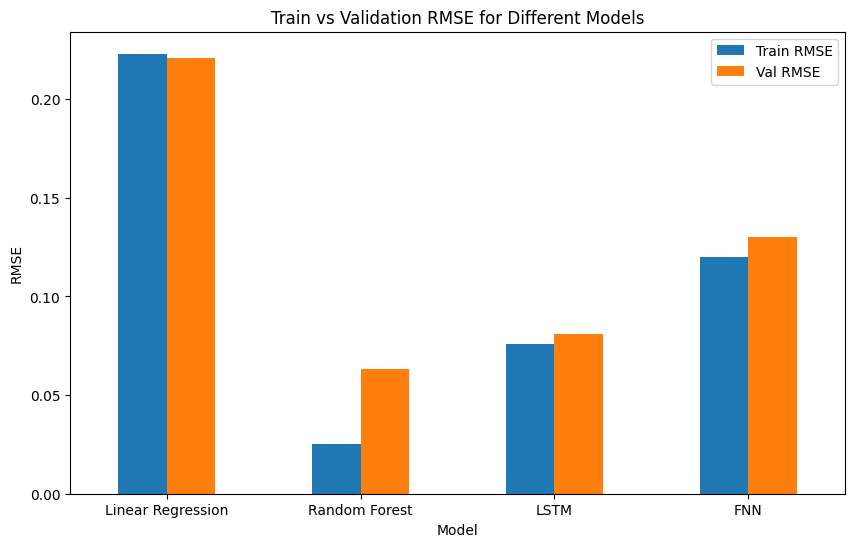

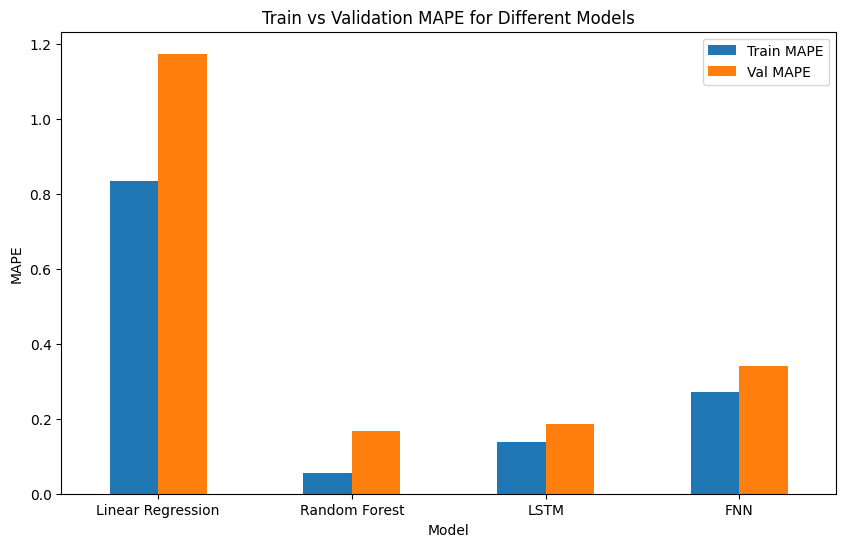

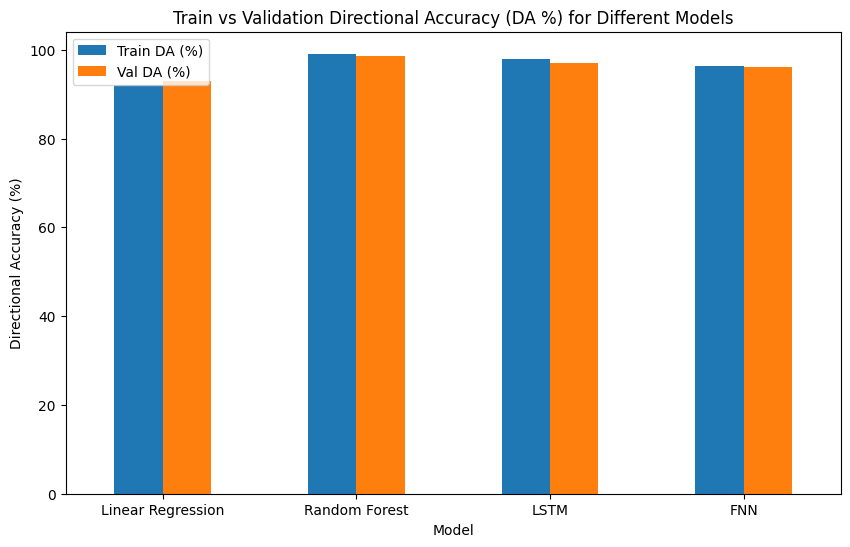

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Data based on the provided table
data = {
    'Model': ['Linear Regression', 'Random Forest', 'LSTM', 'FNN'],
    'Train RMSE': [0.223, 0.025, 0.076, 0.120],
    'Val RMSE': [0.221, 0.063, 0.081, 0.130],
    'Train MAPE': [0.835, 0.056, 0.139, 0.271],
    'Val MAPE': [1.175, 0.168, 0.185, 0.341],
    'Train DA (%)': [92.1, 99.1, 98.0, 96.4],
    'Val DA (%)': [92.9, 98.6, 97.1, 96.0]
}

# Convert to DataFrame
metrics_df = pd.DataFrame(data)

# Plotting the bar chart for RMSE
metrics_df.plot(x='Model', y=['Train RMSE', 'Val RMSE'], kind='bar', figsize=(10, 6))
plt.title('Train vs Validation RMSE for Different Models')
plt.ylabel('RMSE')
plt.xticks(rotation=0)
plt.show()

# Plotting the bar chart for MAPE
metrics_df.plot(x='Model', y=['Train MAPE', 'Val MAPE'], kind='bar', figsize=(10, 6))
plt.title('Train vs Validation MAPE for Different Models')
plt.ylabel('MAPE')
plt.xticks(rotation=0)
plt.show()

# Plotting the bar chart for Directional Accuracy (DA %)
metrics_df.plot(x='Model', y=['Train DA (%)', 'Val DA (%)'], kind='bar', figsize=(10, 6))
plt.title('Train vs Validation Directional Accuracy (DA %) for Different Models')
plt.ylabel('Directional Accuracy (%)')
plt.xticks(rotation=0)
plt.show()

## Final Model Training

In [78]:
X_train_full_lstm = np.reshape(X_train_full.values, (X_train_full.shape[0], X_train_full.shape[1], 1))
X_test_lstm = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))

lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_full_lstm.shape[1], 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
lstm_model.fit(X_train_full_lstm, y_train_full, epochs=600, batch_size=150)

# Make predictions on the test set

y_pred_train = lstm_model.predict(X_train_full_lstm)
y_pred_test = lstm_model.predict(X_test_lstm)

y_train_full.shape, y_pred_train.shape, X_train_full_lstm.shape

lstm_rmse_train, lstm_mape_train, lstm_acc_train = calculate_metrics(y_train_full, y_pred_train)
lstm_rmse_test, lstm_mape_test, lstm_acc_test = calculate_metrics(y_test, y_pred_test)

print(f"LSTM Train RMSE: {lstm_rmse_train}, MAPE: {lstm_mape_train}, Directional Accuracy: {lstm_acc_train}")
print(f"LSTM Test RMSE: {lstm_rmse_test}, MAPE: {lstm_mape_test}, Directional Accuracy: {lstm_acc_test}")

Epoch 1/600
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - loss: 0.6959
Epoch 2/600
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.2183
Epoch 3/600
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.1948
Epoch 4/600
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.1767
Epoch 5/600
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1665
Epoch 6/600
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1571
Epoch 7/600
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.1475
Epoch 8/600
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1451
Epoch 9/600
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1386
Epoch 10/600
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1348
Epoch 11/600
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1255
Epoch 12/600
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1184
Epoch 13/600
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0896
Epoch 14/600
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0809
Epoch 15/600
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - lo